# Оценка рисков ДТП

Необходимо создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Идея решения задачи от заказчика:**
- Создать модель предсказания ДТП. Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП.
- Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
    - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
    - Какие ещё факторы нужно учесть?
    - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
- Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

# План по выполнению проекта
1. Загрузка данных
2. Первичное исследование таблиц
3. Cтатистический анализ факторов ДТП
4. Создание модели для оценки водительского риска
   - 4.1 Поиск лучшей модели
   - 4.2 Проверка лучшей модели
   - 4.3 Общий вывод по модели
5. Анализ важности факторов ДТП
6. Отчет по проекту

# Краткое описание таблиц 

- **collisions** — общая информация о ДТП. Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
- **parties** — Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
- **vehicles** — информация о пострадавших машинах. Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

**Целевой признак**

- **at_fault** — (виновник) в таблице parties

# Загрузка данных

## Импорт библиотек, создание функций

In [1]:
!pip install -q sweetviz
!pip install -q --upgrade scikit-learn
!pip install -q imbalanced-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

#sql
from sqlalchemy import create_engine

#загрузка стандартных библиотек
import pandas as pd
import numpy as np

#графики
import seaborn as sns
from matplotlib import pyplot as plt

#генерация отчетов с визуализацией для выполнения EDA
import sweetviz as sv

#подготовка к созданию ML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline

#балансировка классов
from imblearn.combine import SMOTETomek

# Импорт моделей
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# кросс-валидация 
from sklearn.model_selection import GridSearchCV

# Импорт нужных инструментов для оценки метрики
from sklearn. metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,roc_auc_score, roc_curve

In [3]:
def column_info(table_name, columns):
    
    column_info = []
    for column in columns:
        query = f'''
            SELECT 
                '{column}' AS column_name,
                COUNT({column}) AS count_values,
                COUNT(DISTINCT {column}) AS count_unique_values,
                COUNT(*) - COUNT(DISTINCT {column}) AS count_duplicates,
                SUM(CASE WHEN {column} IS NULL THEN 1 ELSE 0 END) AS count_missing_values
            FROM {table_name};
        '''
        
        result = pd.read_sql_query(query, con)
        column_info.append(result)
    
    return pd.concat(column_info, ignore_index=True)

In [4]:
def plot_column_distribution(df, column_name, xlabel, title):
    '''
    Распределение признака с указанием процента от общего числа
    '''
    # Подсчет количества значений для указанного столбца и сортировка по убыванию
    column_counts = df[column_name].sort_values(ascending=False)

    # Расчет процентного содержания
    total_count = df[column_name].sum()
    percentages = [(count / total_count) * 100 for count in column_counts]

    # Создание столбчатой диаграммы с процентами
    plt.figure(figsize=(15, 5))
    bars = plt.bar(column_counts.index.astype(str), column_counts, color='skyblue')  # Преобразование индекса в строки

    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

    # Добавление заголовков и меток осей
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Количество аварий')

    plt.show()

In [5]:
def plot_column_target(df, column_name, xlabel, title):
    '''
    Распределение признака по таргету с указанием процента от общего числа
    '''
    # Подсчет количества значений для указанного столбца и сортировка по убыванию
    column_counts = df.groupby([df.index, 'at_fault'])[column_name].sum().unstack()

    # Расчет процентного содержания
    total_count = df[column_name].sum()
    percentages_0 = [(count / total_count) * 100 for count in column_counts[0]]
    percentages_1 = [(count / total_count) * 100 for count in column_counts[1]]

    # Создание столбчатой диаграммы с процентами
    plt.figure(figsize=(15, 5))
    bar_width = 0.35
    indices = range(len(column_counts.index))  

    bars1 = plt.bar([idx - bar_width/2 for idx in indices], column_counts[0], width=bar_width, color='skyblue', alpha=0.7, label='at_fault = 0')
    bars2 = plt.bar([idx + bar_width/2 for idx in indices], column_counts[1], width=bar_width, color='salmon', alpha=0.7, label='at_fault = 1')

    for bar, percentage_0, percentage_1, idx in zip(bars1, percentages_0, percentages_1, indices):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage_0:.1f}%', ha='center', va='bottom')
        plt.text(bar.get_x() + bar.get_width() / 2, 0, column_counts.index[idx], ha='center', va='top')  

    for bar, percentage_1, idx in zip(bars2, percentages_1, indices):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage_1:.1f}%', ha='center', va='bottom')
        plt.text(bar.get_x() + bar.get_width() / 2, 0, column_counts.index[idx], ha='center', va='top')  

    # Добавление заголовков и меток осей
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Количество аварий')
    plt.legend()

    plt.show()

In [6]:
def guilt_percentage(dataset_name):
    type_of_col = dataset_name.pivot(columns='at_fault', values='count')
    type_of_col['guilt_percentage'] = round(type_of_col[1] / (type_of_col[0] + type_of_col[1]) * 100, 2)
    return type_of_col.sort_values(by='guilt_percentage', ascending=False)

In [7]:
#поиск лучшей модели бустинга
def best_model_boost(results):
    lgbm = results.query('model_name == "LGBMClassifier"').sort_values(by=['mean_test_score',
                                                                           'mean_fit_time',
                                                                           'mean_score_time'],
                                                                       ascending=[False, True, True]).iloc[0]

    cbc = results.query('model_name == "CatBoostClassifier"').sort_values(by=['mean_test_score',
                                                                              'mean_fit_time',
                                                                              'mean_score_time'],
                                                                          ascending=[False, True, True]).iloc[0]

    best_models = pd.DataFrame([lgbm, cbc])
    return best_models

In [8]:
def results():
    results_df = pd.DataFrame(grid.cv_results_)
    results_df['model_name'] = results_df['param_model'].apply(lambda x: type(x).__name__)

    expected_columns = [
        'param_model__n_estimators', 'param_model__learning_rate', 'param_model__max_depth', 
        'param_model__iterations', 'param_model__depth', 'mean_fit_time', 
        'mean_score_time', 'mean_test_score'
    ]

    results_df = results_df[['model_name'] + [col for col in expected_columns if col in results_df.columns]]

    results_df['mean_test_score'] = round(results_df['mean_test_score'], 2)
    results_df['mean_score_time'] = round(results_df['mean_score_time'], 2)
    results_df['mean_fit_time'] = round(results_df['mean_fit_time'], 2)
    
    best_models = best_model_boost(results_df)
    return best_models

In [9]:
# Функция для вывода результатов лучшей модели RandomForest
def best_random_forest_model(grid):
    results = pd.DataFrame(grid.cv_results_)
    best_index = grid.best_index_
    
    best_rf = results.loc[best_index]
    display_columns = ['param_randomforestclassifier__n_estimators', 
                       'param_randomforestclassifier__max_depth', 
                       'param_randomforestclassifier__min_samples_split', 
                       'mean_fit_time', 'mean_score_time', 'mean_test_score']
    
    best_rf_display = best_rf[display_columns]
    
    # Округление до двух знаков 
    best_rf_display['mean_fit_time'] = round(best_rf_display['mean_fit_time'], 2)
    best_rf_display['mean_score_time'] = round(best_rf_display['mean_score_time'], 2)
    best_rf_display['mean_test_score'] = round(best_rf_display['mean_test_score'], 2)
    
    best_rf_display = pd.DataFrame(best_rf_display).transpose()
    
    return best_rf_display

## Подключение к базе данных 

In [10]:
#Подключение к базе данных

db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

con = create_engine(connection_string)

# Первичное исследование таблиц

## Проверка соответствия количества таблиц и их названий

In [11]:
#выгрузка таблицы parties
information_schema_query = '''
                            SELECT table_name
                            FROM information_schema.tables
                            WHERE table_schema = 'public'
                            ORDER BY table_name;
                            '''

information_schema = pd.read_sql_query(information_schema_query, con=con)
information_schema

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


Количество таблиц и названия соответствуют условию задачи

## Проверка набора данных в таблицах

### Таблица case_ids

In [12]:
#информация о таблице 'case_ids'

information_schema_case_ids_query = '''
                                    SELECT column_name, data_type
                                    FROM information_schema.columns
                                    WHERE table_name = 'case_ids';
                                    '''
information_schema_case_ids = pd.read_sql_query(information_schema_case_ids_query, con=con)
information_schema_case_ids

,column_name,data_type
0,case_id,text
1,db_year,text


Названия окон не соответствует ER - диаграмме: отсутствует информция о `db_year` 

In [13]:
#первые пять строк case_ids
case_ids_limit_5_query = '''
                 SELECT *
                 FROM case_ids
                 LIMIT 5;'''

case_ids_limit_5 = pd.read_sql_query(case_ids_limit_5_query, con=con)
case_ids_limit_5

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [14]:
table_name = 'case_ids'
columns = ['case_id', 'db_year']
display(column_info(table_name, columns))

,column_name,count_values,count_unique_values,count_duplicates,count_missing_values
0,case_id,1400000,1400000,0,0
1,db_year,1400000,1,1399999,0


In [15]:
#проверка на наличие дубликатов в таблице
case_ids_duplications_query = '''
                SELECT COUNT(*)
                FROM case_ids
                GROUP BY case_id, db_year
                HAVING COUNT(*) > 1;
                '''

case_ids_duplications = pd.read_sql_query(case_ids_duplications_query, con=con)
case_ids_duplications

,count


- Названия окон не соответствует ER - диаграмме: отсутствует информция о db_year. Вероятно, это год создания таблицы (2021)
- Все case_id уникальны
- Количество строк: 1 400 000. Формат строк в sql: text.
- Пропуски отсутствуют, дубликаты отсутствуют

### Таблица vehicles (описание автомобиля)

In [16]:
#информация о таблице 'vehicles'

information_vehicles_query = '''
                                    SELECT column_name, data_type
                                    FROM information_schema.columns
                                    WHERE table_name = 'vehicles';
                                    '''
information_vehicles = pd.read_sql_query(information_vehicles_query, con=con)
information_vehicles

,column_name,data_type
0,id,integer
1,party_number,integer
2,vehicle_age,integer
3,case_id,text
4,vehicle_type,text
5,vehicle_transmission,text


Названия и количество окон соответствует ER - диаграмме.

In [17]:
#первые пять строк vehicles
vehicles_limit_5_query = '''
                 SELECT *
                 FROM vehicles
                 LIMIT 5;'''

vehicles_limit_5 = pd.read_sql_query(vehicles_limit_5_query, con=con)
vehicles_limit_5

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [18]:
table_name = 'vehicles'
columns = ['id', 'case_id', 'party_number', 'vehicle_type', 'vehicle_transmission', 'vehicle_age']
display(column_info(table_name, columns))

,column_name,count_values,count_unique_values,count_duplicates,count_missing_values
0,id,1021234,1021234,0,0
1,case_id,1021234,792642,228592,0
2,party_number,1021234,27,1021207,0
3,vehicle_type,1021234,5,1021229,0
4,vehicle_transmission,997575,2,1021232,23659
5,vehicle_age,996652,22,1021212,24582


In [19]:
#проверка на наличие дубликатов в таблице
vehicles_duplications_query = '''
                SELECT COUNT(*)
                FROM vehicles
                GROUP BY id, case_id, party_number, vehicle_type, vehicle_transmission, vehicle_age
                HAVING COUNT(*) > 1;
                '''

vehicles_duplications = pd.read_sql_query(vehicles_duplications_query, con=con)
vehicles_duplications

,count


- Названия и количество окон соответствует ER - диаграмме.
- Общее количество строк: 1 021 234, в столбцах vehicle_transmission и vehicle_age есть пропуски, количество пропусков соответственно 23659 и 24582
- Есть дублирующиеся значения в case_id, возможно это значит, что постарадавших машин в одной ситуации могло быть несколько
- Для столбцов id, party_number, vehicle_age тип строк в sql: integer.
- Для столбцов case_id, vehicle_type, vehicle_transmission тип строк в sql: text.

### Таблица collisions (информация о происшествиях)

In [20]:
#информация о таблице 'collisions'

information_collisions_query = '''
                                    SELECT column_name, data_type
                                    FROM information_schema.columns
                                    WHERE table_name = 'collisions';
                                    '''
information_collisions = pd.read_sql_query(information_collisions_query, con=con)
information_collisions

,column_name,data_type
0,party_count,integer
1,intersection,integer
2,distance,real
3,collision_date,date
4,collision_time,time without time zone
5,location_type,text
6,collision_damage,text
7,case_id,text
8,pcf_violation_category,text
9,type_of_collision,text


Названия и количество окон соответствует ER - диаграмме.

In [21]:
#первые пять строк collisions
collisions_limit_5_query = '''
                 SELECT *
                 FROM collisions
                 LIMIT 5;'''

collisions_limit_5 = pd.read_sql_query(collisions_limit_5_query, con=con)
collisions_limit_5

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [22]:
table_name = 'collisions'
columns = ['case_id',
           'county_city_location',
           'county_location',
           'distance',
           'direction',
           'intersection',
           'weather_1',
           'location_type',
           'collision_damage',
           'party_count',
           'primary_collision_factor',
           'pcf_violation_category',
           'type_of_collision',
           'motor_vehicle_involved_with',
           'road_surface',
           'road_condition_1',
           'lighting',
           'control_device',
           'collision_date',
           'collision_time'
          ]
display(column_info(table_name, columns))

,column_name,count_values,count_unique_values,count_duplicates,count_missing_values
0,case_id,1400000,1400000,0,0
1,county_city_location,1400000,538,1399462,0
2,county_location,1400000,58,1399942,0
3,distance,1400000,5071,1394929,0
4,direction,1059358,4,1399996,340642
5,intersection,1387781,2,1399998,12219
6,weather_1,1392741,7,1399993,7259
7,location_type,518779,3,1399997,881221
8,collision_damage,1400000,5,1399995,0
9,party_count,1400000,18,1399982,0


In [23]:
#проверка на наличие дубликатов в таблице
collisions_duplications_query = '''
                SELECT COUNT(*)
                FROM collisions
                GROUP BY case_id,
                         county_city_location,
                         county_location,
                         distance,
                         direction,
                         intersection,
                         weather_1,
                         location_type,
                         collision_damage,
                         party_count,
                         primary_collision_factor,
                         pcf_violation_category,
                         type_of_collision,
                         motor_vehicle_involved_with,
                         road_surface,
                         road_condition_1,
                         lighting,
                         control_device,
                         collision_date,
                         collision_time
                HAVING COUNT(*) > 1;
                '''

collisions_duplications = pd.read_sql_query(collisions_duplications_query, con=con)
collisions_duplications

,count


- Названия и количество окон соответствует ER - диаграмме.
- Общее количество строк: 1 400 000. Все case_id уникальны. 
- Столбцы, в которых нет пропусков:
    - case_id,
    - county_city_location,
    - county_location,
    - distance,
    - collision_damage,
    - party_count
    - collision_date

- Для столбцов party_count, intersection тип строк в sql: integer.
   - distance: real
   - collision_date:date
   - collision_time: time without time zone
   - остальные столбцы с типом данных text.

- дубликаты отсутствуют

### Таблица parties (описание участников происшествия)

In [24]:
#информация о таблице 'parties'

information_parties_query = '''
                                    SELECT column_name, data_type
                                    FROM information_schema.columns
                                    WHERE table_name = 'parties';
                                    '''
information_parties = pd.read_sql_query(information_parties_query, con=con)
information_parties

,column_name,data_type
0,cellphone_in_use,integer
1,party_number,integer
2,at_fault,integer
3,insurance_premium,integer
4,id,integer
5,case_id,text
6,party_drug_physical,text
7,party_type,text
8,party_sobriety,text


Названия и количество окон соответствует ER - диаграмме.

In [25]:
#первые пять строк parties
parties_limit_5_query = '''
                 SELECT *
                 FROM parties
                 LIMIT 5;'''

parties_limit_5 = pd.read_sql_query(parties_limit_5_query, con=con)
parties_limit_5

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [26]:
table_name = 'parties'
columns = ['id',
           'case_id',
           'party_number',
           'party_type',
           'at_fault',
           'insurance_premium',
           'party_sobriety',
           'party_drug_physical',
           'cellphone_in_use'
          ]
display(column_info(table_name, columns))

,column_name,count_values,count_unique_values,count_duplicates,count_missing_values
0,id,2752408,2752408,0,0
1,case_id,2752408,1400000,1352408,0
2,party_number,2752408,27,2752381,0
3,party_type,2748786,5,2752403,3622
4,at_fault,2752408,2,2752406,0
5,insurance_premium,2347006,106,2752302,405402
6,party_sobriety,2678453,6,2752402,73955
7,party_drug_physical,432288,5,2752403,2320120
8,cellphone_in_use,2240771,2,2752406,511637


In [27]:
#проверка на наличие дубликатов в таблицу
parties_duplications_query = '''
                SELECT COUNT(*)
                FROM parties
                GROUP BY    id,
                            case_id,
                            party_number,
                            party_type,
                            at_fault,
                            insurance_premium,
                            party_sobriety,
                            party_drug_physical,
                            cellphone_in_use
                HAVING COUNT(*) > 1;
                '''

parties_duplications = pd.read_sql_query(parties_duplications_query, con=con)
parties_duplications

,count


- Названия и количество окон соответствует ER - диаграмме.
- Общее количество строк: 2 752 408. 1 400 000 case_id уникальны. 
- Столбцы, в которых нет пропусков:
    - id,
    - case_id,
    - party_number,
    - at_fault

- Для столбцов cellphone_in_use, party_number, at_fault, insurance_premium, id	тип строк в sql: integer.
    - case_id, party_drug_physical, party_type, party_sobriety с типом данных text.
- дубликаты в таблице отсутствуют

## Проверка общего ключа

In [28]:
info_schema_query = '''SELECT *
                       FROM information_schema.key_column_usage
                       WHERE constraint_schema	 = 'public'
                       '''

# Передача SQL-запроса
info_schema = pd.read_sql_query(info_schema_query, con=con)
pd.set_option('display.max_columns', None)
info_schema

,constraint_catalog,constraint_schema,constraint_name,table_catalog,table_schema,table_name,column_name,ordinal_position,position_in_unique_constraint
0,data-science-vehicle-db,public,case_ids_pk,data-science-vehicle-db,public,case_ids,case_id,1,NaN
1,data-science-vehicle-db,public,parties_pk,data-science-vehicle-db,public,parties,id,1,NaN
2,data-science-vehicle-db,public,vehicles_pk,data-science-vehicle-db,public,vehicles,id,1,NaN
3,data-science-vehicle-db,public,collisions_case_ids_case_id_fk,data-science-vehicle-db,public,collisions,case_id,1,1.0
4,data-science-vehicle-db,public,parties_case_ids_case_id_fk,data-science-vehicle-db,public,parties,case_id,1,1.0
5,data-science-vehicle-db,public,vehicles_case_ids_case_id_fk,data-science-vehicle-db,public,vehicles,case_id,1,1.0


Общий ключ действительно есть и это case_id

#  Статистический анализ факторов ДТП

## Месяцы, в которые происходит наибольшее количество аварий

In [29]:
collisions_month_query = '''
                 SELECT EXTRACT(MONTH FROM COLLISION_DATE) AS MONTH, COUNT(EXTRACT(MONTH FROM COLLISION_DATE)) AS count_collisions
                 FROM collisions
        
                 WHERE COLLISION_DAMAGE != 'scratch'
                 GROUP BY EXTRACT(MONTH FROM COLLISION_DATE)
                 '''

collisions_month = pd.read_sql_query(collisions_month_query, con=con)
collisions_month.set_index('month', inplace=True)

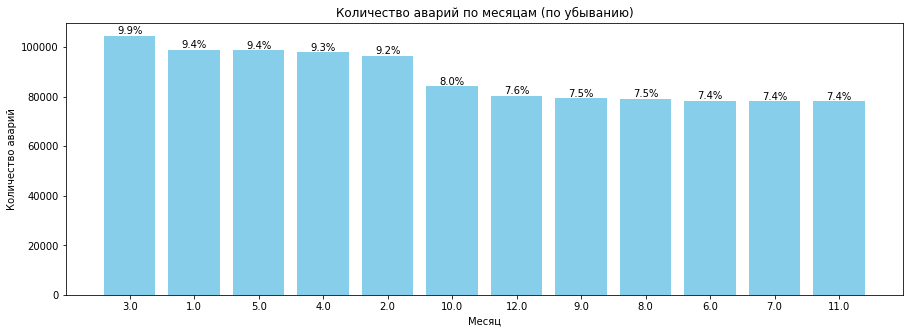

In [30]:
plot_column_distribution(collisions_month, 'count_collisions', 'Месяц', 'Количество аварий по месяцам (по убыванию)')

- Больше всего аварий происходит в первой половине года, с января по май (9.2-9.9%): максимум в марте, ниже всего в феврале.
- Во второй половине года с июня по декабрь диапозон: 7.4-8%. Меньше всего в июне, июле и ноябре (по 7.4%)

## Создание аналитических задач с использованием статистического анализа данных

Скоро состоится первое совещание моей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого я должна создать подходящие аналитические задачи и поручить их решение коллегам. Ниже будут представлены формулировки задач и мои собственные решения. Необходимо прописать порядок решения для двух задач из списка.

### Динамика аварий по годам

Задача 1. Необходимо проверить динамику по годам, чтобы убедиться в полноте данных

In [31]:
collisions_year_query = '''
                 SELECT EXTRACT(YEAR FROM COLLISION_DATE) AS YEAR, COUNT(EXTRACT(YEAR FROM COLLISION_DATE)) AS count_collisions
                 FROM collisions
        
                 WHERE COLLISION_DAMAGE != 'scratch'
                 GROUP BY EXTRACT(YEAR FROM COLLISION_DATE)
                 '''

collisions_year = pd.read_sql_query(collisions_year_query, con=con)
collisions_year.set_index('year', inplace=True)

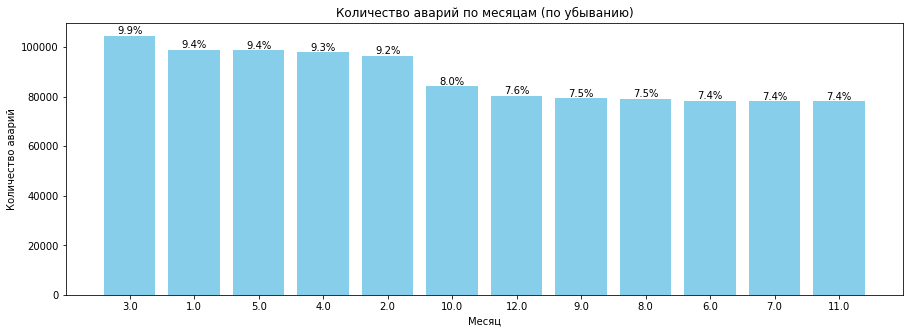

In [32]:
plot_column_distribution(collisions_month, 'count_collisions', 'Месяц', 'Количество аварий по месяцам (по убыванию)')

In [33]:
collisions_year

,count_collisions
year,
2009.0,322957
2010.0,313614
2011.0,301357
2012.0,115666
2013.0,298
2020.0,2


Большая часть данных об авариях относится к 2009 году - 30.6%. Также имеется информация о 2010 годе - 29.8%, 2011 годе - 28.6% и 2012 годе - 11%. Доля данных о 2013 году составляет менее одного процента, а всего две записи относятся к 2020 году, что может указывать на наличие аномалии в данных.

### Дни недели, в которые происходит наибольшее количество аварий

Задача 2. Необходимо проанализировать изменение числа аварий в зависимости от дня недели, чтобы определить возможные различия между буднями и выходными.

In [34]:
collisions_week_query = '''
                 SELECT 
                 CASE 
                     WHEN EXTRACT(DOW FROM COLLISION_DATE) = 0 THEN 'Sunday'
                     WHEN EXTRACT(DOW FROM COLLISION_DATE) = 1 THEN 'Monday'
                     WHEN EXTRACT(DOW FROM COLLISION_DATE) = 2 THEN 'Tuesday'
                     WHEN EXTRACT(DOW FROM COLLISION_DATE) = 3 THEN 'Wednesday'
                     WHEN EXTRACT(DOW FROM COLLISION_DATE) = 4 THEN 'Thursday'
                     WHEN EXTRACT(DOW FROM COLLISION_DATE) = 5 THEN 'Friday'
                     WHEN EXTRACT(DOW FROM COLLISION_DATE) = 6 THEN 'Saturday'
                 END AS DAY_OF_WEEK, 
                 COUNT(*) AS count_collisions
                 FROM collisions
                 WHERE COLLISION_DAMAGE != 'scratch'
                 GROUP BY EXTRACT(DOW FROM COLLISION_DATE)
                 '''

collisions_week = pd.read_sql_query(collisions_week_query, con=con)
collisions_week.set_index('day_of_week', inplace=True)


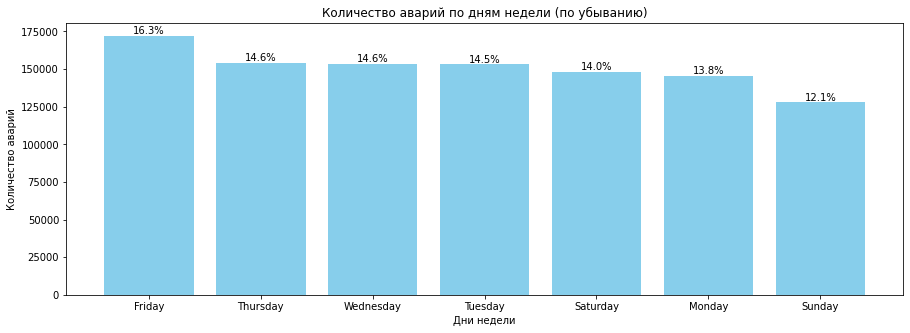

In [35]:
plot_column_distribution(collisions_week, 'count_collisions', 'Дни недели', 'Количество аварий по дням недели (по убыванию)')

Чаще всего происходят аварии по пятницам - в 16.3% случаев, в понедельник и в воскресенье вероятность наиболее низкая - 13.8% и 12.1% соответственно

### Часы, в которые происходит наибольшее количество аварий

Задача 3. Необходимо проанализировать часы, в которые происходит наибольшее количество аварий, для выявления временных пиков аварийности

In [36]:
collisions_hour_query = '''
                 SELECT DATE_PART('hour', collision_time) AS HOUR, COUNT(*) AS count_collisions
                 FROM collisions
                 WHERE COLLISION_DAMAGE != 'scratch' AND collision_time IS NOT NULL
                 GROUP BY DATE_PART('hour', collision_time)
                 '''

collisions_hour = pd.read_sql_query(collisions_hour_query, con=con)
collisions_hour.set_index('hour', inplace=True)

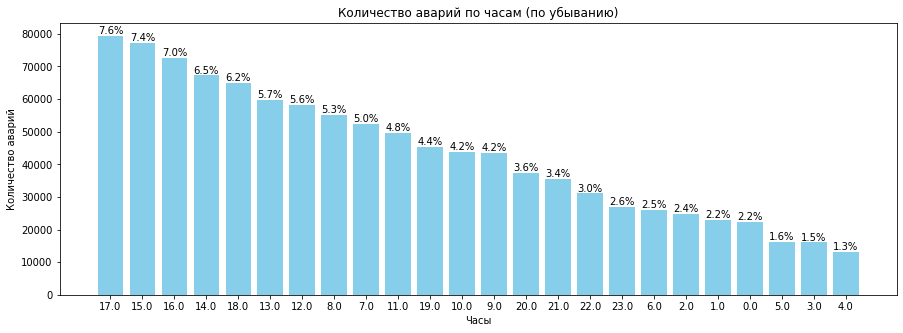

In [37]:
plot_column_distribution(collisions_hour, 'count_collisions', 'Часы', 'Количество аварий по часам (по убыванию)')

Чаще всего аварии происходят с 15 по 17 часов, на это время приходится 22,0% случаев. 
Реже всего аварии происходят с 0 до 6 утра на это время приходится 13,7% случаев.

### Анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент аварии

Задача 4. Изучение серьезности повреждений транспортного средства в зависимости от состояния дороги в момент ДТП:

Шаги анализа:
1. Сформулируйте SQL-запрос для объединения таблиц collisions (информация о происшествиях) и parties (описание участников происшествия).
2. Постройте график, отображающий 'Количество аварий в зависимости от состояния дороги в момент происшествия'.
3. Сделайте соответствующий вывод.

Изучение взаимосвязи вероятности виновности водителя с состоянием дороги и степенью повреждения автомобиля:

Дополнительные шаги:
1. Оцените влияние состояния дороги и степени повреждения автомобиля на вероятность виновности водителя.
2. Постройте отдельные графики для каждого типа повреждения автомобиля.
3. Сделайте соответствующие выводы.

In [38]:
damage_road_query = '''
                 SELECT ROAD_SURFACE, COLLISION_DAMAGE, at_fault, COUNT(at_fault)
                 FROM collisions c
                 JOIN parties p ON c.case_id = p.case_id
                       AND road_surface IS NOT NULL
                 GROUP BY road_surface, collision_damage, at_fault
            
                 '''

damage_road = pd.read_sql_query(damage_road_query, con=con)
damage_road.head(10)

,road_surface,collision_damage,at_fault,count
0,dry,fatal,0,8983
1,dry,fatal,1,9236
2,dry,middle damage,0,148107
3,dry,middle damage,1,140790
4,dry,scratch,0,370178
5,dry,scratch,1,288690
6,dry,severe damage,0,25082
7,dry,severe damage,1,26033
8,dry,small damage,0,773275
9,dry,small damage,1,677665


In [39]:
# converting column to index
damage_road.set_index('road_surface', inplace=True)

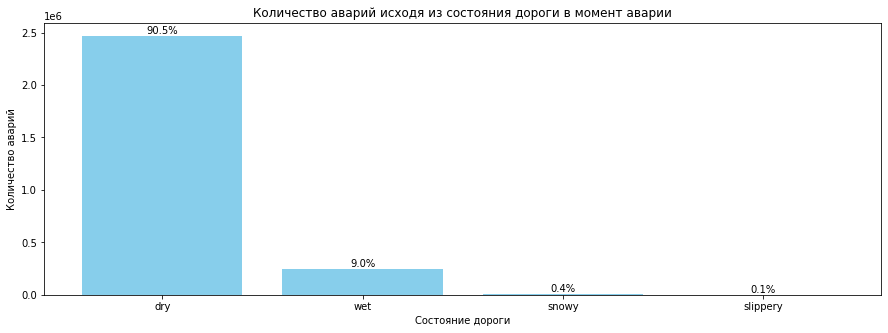

In [40]:
plot_column_distribution(damage_road.groupby(damage_road.index).sum(), 'count', 'Состояние дороги', 'Количество аварий исходя из состояния дороги в момент аварии')

Большинство аварий, 90.5%, случаются на сухих дорогах, 9.0% - на влажных, 0.5% - на заснеженных и 0.1% - на грязных. Это обусловлено преимущественно тем, что в сухую погоду больше людей выбираются на дорогу, а в дождливую или снежную погоду предпочитают воздержаться от поездок.

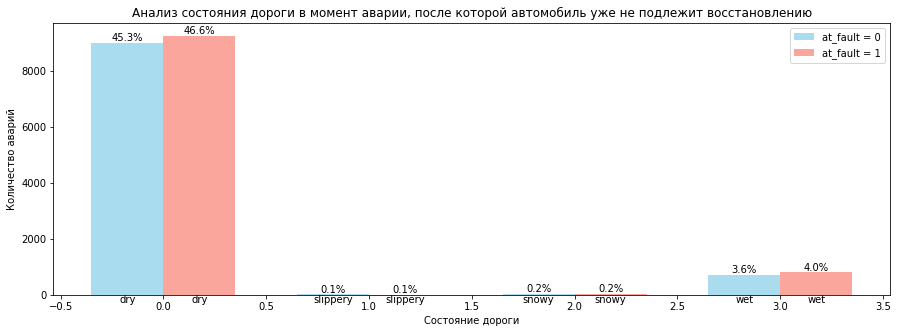

In [41]:
plot_column_target(damage_road[(damage_road['collision_damage'] == 'fatal')], 'count', 'Состояние дороги', 'Анализ состояния дороги в момент аварии, после которой автомобиль уже не подлежит восстановлению')

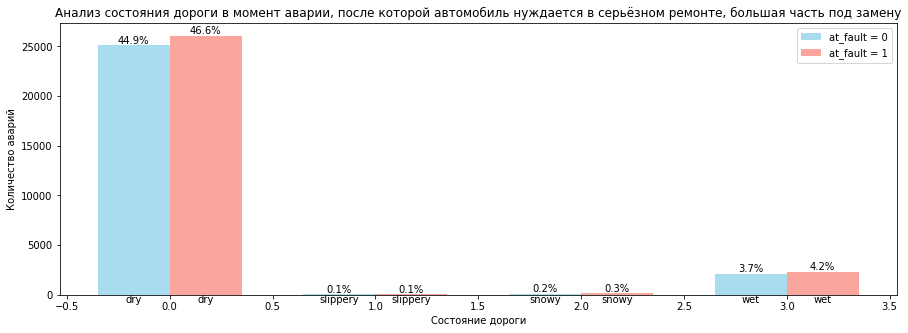

In [42]:
plot_column_target(damage_road[(damage_road['collision_damage'] == 'severe damage')],
                         'count',
                         'Состояние дороги',
                         'Анализ состояния дороги в момент аварии, после которой автомобиль нуждается в серьёзном ремонте, большая часть под замену')

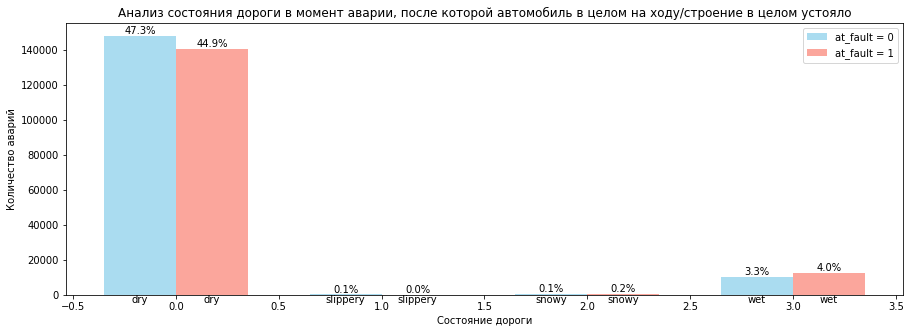

In [43]:
plot_column_target(damage_road[(damage_road['collision_damage'] == 'middle damage')],
                         'count',
                         'Состояние дороги',
                         'Анализ состояния дороги в момент аварии, после которой автомобиль в целом на ходу/строение в целом устояло')

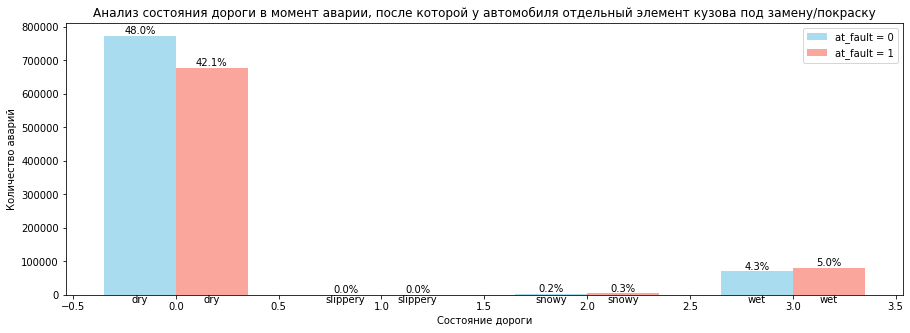

In [44]:
plot_column_target(damage_road[(damage_road['collision_damage'] == 'small damage')],
                         'count',
                         'Состояние дороги',
                         'Анализ состояния дороги в момент аварии, после которой у автомобиля отдельный элемент кузова под замену/покраску')

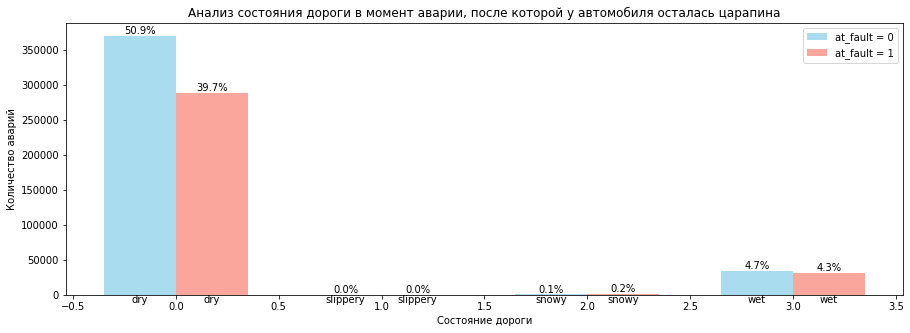

In [45]:
plot_column_target(damage_road[(damage_road['collision_damage'] == 'scratch')],
                         'count',
                         'Состояние дороги',
                         'Анализ состояния дороги в момент аварии, после которой у автомобиля осталась царапина')

Из анализа графиков следует, что в случае серьезных аварий, когда автомобиль не подлежит восстановлению, чуть больше случаев, когда виноват клиент - 45.3% и 44.9% соответственно. В случае менее серьезных происшествий, когда повреждения автомобиля легко устранимы, например, при царапинах, вероятность невиновности клиента выше. При этом, при влажной погоде, наличии снега или грязи, чаще виноватым оказывается клиент, за исключением случаев получения царапин при влажной погоде, где вероятность невиновности немного выше - 4.7% против 4.3%.

### Самые частые причины ДТП

#### В зависимости от участника происшествия

Задача 5. Исследуйте различные категории участников дорожно-транспортных происшествий и оцените вероятность аварии с каждой из них. Проведите анализ, чтобы определить вероятность стать виновником аварии в зависимости от участника ДТП. 

In [46]:
party_type_query = '''
                 SELECT party_type, at_fault, COUNT(at_fault)
                 FROM parties
                 WHERE party_type IS NOT NULL
                 GROUP BY party_type, at_fault
                 '''

party_type = pd.read_sql_query(party_type_query, con=con)
party_type

,party_type,at_fault,count
0,building,0,21322
1,building,1,27327
2,car,0,1228964
3,car,1,1240350
4,other,0,7118
5,other,1,1761
6,road bumper,0,171898
7,road bumper,1,1590
8,road signs,0,33192
9,road signs,1,15264


In [47]:
# converting column to index
party_type.set_index('party_type', inplace=True)

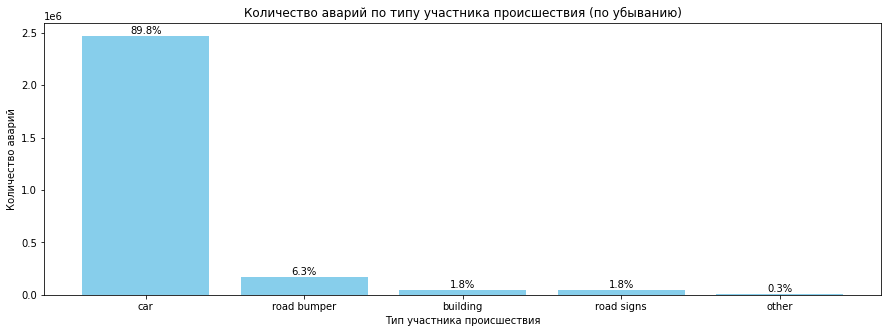

In [48]:
plot_column_distribution(party_type.groupby(party_type.index).sum(), 'count', 'Тип участника происшествия', 'Количество аварий по типу участника происшествия (по убыванию)')

89.8% участников аварии это другие машины, 6.3% дорожные знаки, 1.8% строения и отбойник, другие - 0.3%

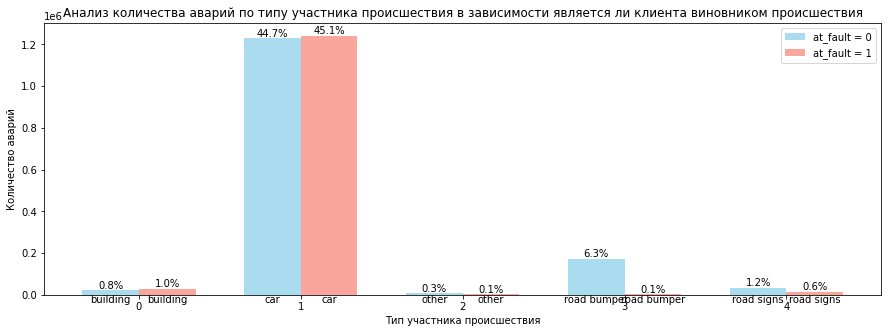

In [49]:
plot_column_target(party_type,
                         'count',
                         'Тип участника происшествия',
                         'Анализ количества аварий по типу участника происшествия в зависимости является ли клиента виновником происшествия')

В 45.1% случаев аварий с участием других автомобилей, клиент является ответственным за произошедшее. Если причиной аварии стали дорожные знаки, отбойник или другие факторы, то чаще всего клиент оказывается не виновным. В случае аварии, связанной со строением, вероятность того, что клиент виноват, немного выше: 1% против 0.8%.

#### В зависимости от состояния водителя

Задача 6. Изучите вероятность возникновения аварии в зависимости от психофизического состояния водителя. Проанализируйте также связь между категориями состояния и вероятностью стать виновником аварии. 

In [50]:
party_drug_physical_query = '''
                 SELECT PARTY_DRUG_PHYSICAL, at_fault, COUNT(at_fault)
                 FROM parties
                 WHERE PARTY_DRUG_PHYSICAL IS NOT NULL
                 GROUP BY PARTY_DRUG_PHYSICAL, at_fault
                 '''

party_drug_physical = pd.read_sql_query(party_drug_physical_query, con=con)
party_drug_physical

,party_drug_physical,at_fault,count
0,G,0,50177
1,G,1,182724
2,impairment - physical,0,2314
3,impairment - physical,1,1874
4,not applicable,0,156542
5,not applicable,1,12801
6,sleepy/fatigued,0,575
7,sleepy/fatigued,1,12066
8,under drug influence,0,1054
9,under drug influence,1,12161


In [51]:
#converting column to index
party_drug_physical.set_index('party_drug_physical', inplace=True)

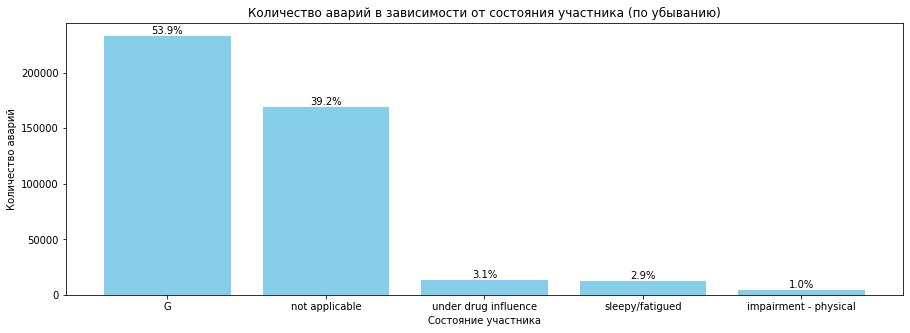

In [52]:
plot_column_distribution(party_drug_physical.groupby(party_drug_physical.index).sum(), 'count', 'Состояние участника', 'Количество аварий в зависимости от состояния участника (по убыванию)')

Более чем в половине случаев (53.9%) неизвестно состояние участника аварии. В 39.2% случаев состояние не было установлено. 3.1% случаев связаны с воздействием лекарств, 2.9% - сонными и уставшими участниками, а в 1% случаев - при ухудшении состояния.

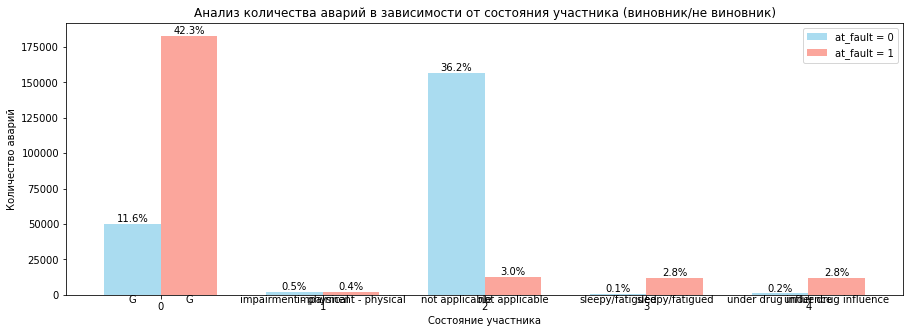

In [53]:
plot_column_target(party_drug_physical,
                         'count',
                         'Состояние участника',
                         'Анализ количества аварий в зависимости от состояния участника (виновник/не виновник)')

Удивительно, что когда состояние участника неизвестно в момент аварии, он оказывается виновным в 42.3% случаев (против 11.6%). При отсутствии установленного состояния, виновен лишь в 3% случаев (против 36,2%), хотя эти два показателя практически одинаковы. В случае ухудшения состояния участника, чаще всего он оказывается невиновным - 0.5% против 0.4%. Когда участник сонный, засыпает или находится под воздействием лекарств, вероятность его вины выше: 2.8% против 0.1% и 0.2% соответственно.

#### Трезвость участника

Задача 7. Изучите вероятность возникновения аварии в зависимости от степени трезвости водителя. Проанализируйте также связь между категориями состояния и вероятностью стать виновником аварии. 

In [54]:
party_sobriety_query = '''
                 SELECT PARTY_SOBRIETY, at_fault, COUNT(at_fault)
                 FROM parties
                 WHERE PARTY_SOBRIETY IS NOT NULL
                 GROUP BY PARTY_SOBRIETY, at_fault
                 '''

party_sobriety = pd.read_sql_query(party_sobriety_query, con=con)
party_sobriety

,party_sobriety,at_fault,count
0,"had been drinking, impairment unknown",0,4367
1,"had been drinking, impairment unknown",1,17052
2,"had been drinking, not under influence",0,5706
3,"had been drinking, not under influence",1,11944
4,"had been drinking, under influence",0,6467
5,"had been drinking, under influence",1,105946
6,had not been drinking,0,1195907
7,had not been drinking,1,928820
8,impairment unknown,0,50177
9,impairment unknown,1,182724


In [55]:
#converting column to index
party_sobriety.set_index('party_sobriety', inplace=True)

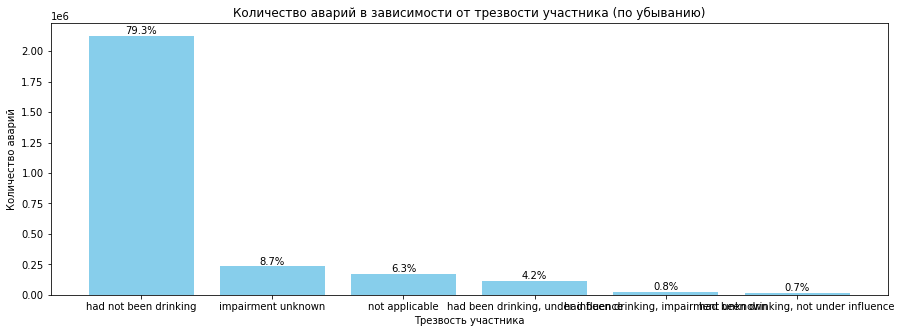

In [56]:
plot_column_distribution(party_sobriety.groupby(party_sobriety.index).sum(),
                         'count',
                         'Трезвость участника',
                         'Количество аварий в зависимости от трезвости участника (по убыванию)')

В 79.3% случаев участник аварии находился в трезвом состоянии. В ситуациях, когда информация об ухудшении состояния неизвестна или не установлена, процент аварий составляет 8.7% и 6.3% соответственно. В оставшихся 5.7% случаев участник был определенно пьян: из них в 4.2% случаев авария произошла под влиянием алкоголя.

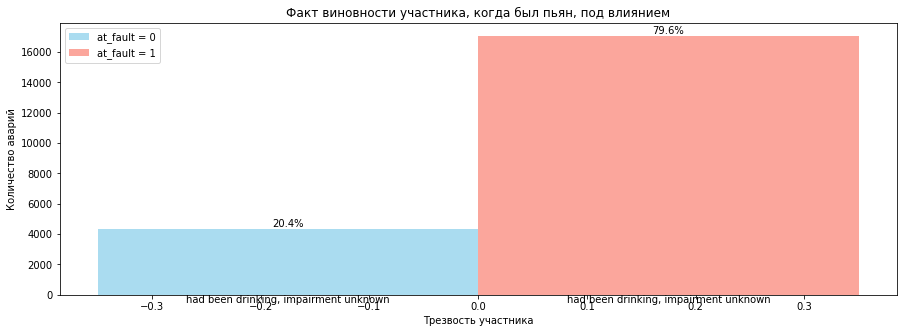

In [57]:
plot_column_target(party_sobriety[:2],
                         'count',
                         'Трезвость участника',
                         'Факт виновности участника, когда был пьян, под влиянием')

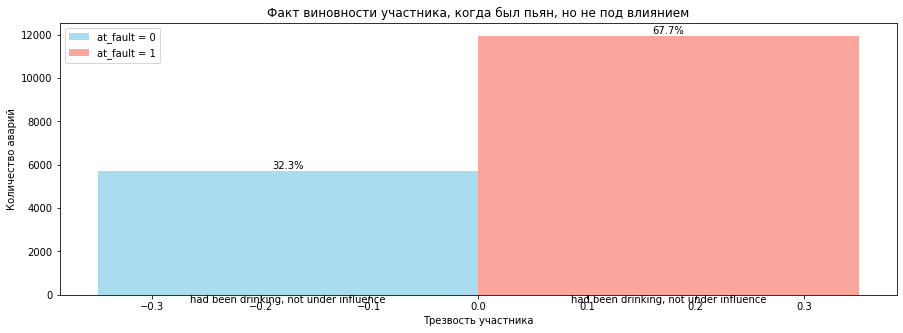

In [58]:
plot_column_target(party_sobriety[2:4],
                         'count',
                         'Трезвость участника',
                         'Факт виновности участника, когда был пьян, но не под влиянием')

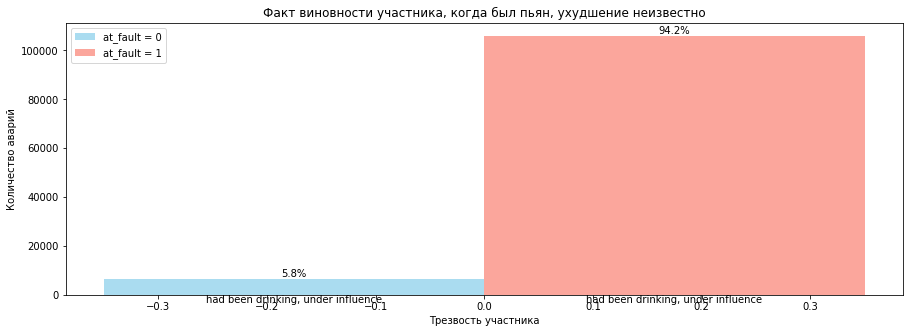

In [59]:
plot_column_target(party_sobriety[4:6],
                         'count',
                         'Трезвость участника',
                         'Факт виновности участника, когда был пьян, ухудшение неизвестно')

Из анализа графиков следует, что вероятность того, что пьяный водитель станет виновником аварии, значительно выше. Если подтверждено воздействие алкоголя на водителя, вероятность его вины составляет 79.6%; в случае отсутствия влияния алкоголя - 67.7%; при неизвестной степени воздействия алкоголя - 94.2%.

#### Наличие телефона в машине

Задача 8. Изучите вероятность возникновения аварии в зависимости от наличия телефона в машине водителя. Проанализируйте также связь между наличием телефона и вероятностью стать виновником аварии. 

In [60]:
cellphone_query = '''
                 SELECT CELLPHONE_IN_USE, at_fault, COUNT(at_fault)
                 FROM parties
                 WHERE CELLPHONE_IN_USE IS NOT NULL
                 GROUP BY CELLPHONE_IN_USE, at_fault
                 '''

cellphone = pd.read_sql_query(cellphone_query, con=con)
cellphone

,cellphone_in_use,at_fault,count
0,0,0,1155932
1,0,1,1039014
2,1,0,21053
3,1,1,24772


In [61]:
#converting column to index
cellphone.set_index('cellphone_in_use', inplace=True)

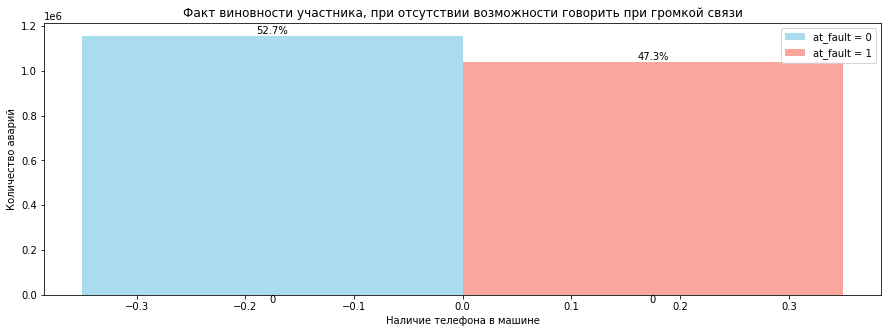

In [62]:
plot_column_target(cellphone[:2],
                         'count',
                         'Наличие телефона в машине',
                         'Факт виновности участника, при отсутствии возможности говорить при громкой связи')

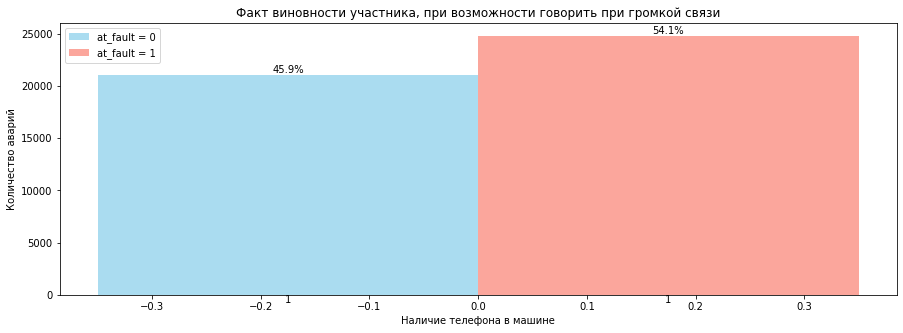

In [63]:
plot_column_target(cellphone[2:4],
                         'count',
                         'Наличие телефона в машине',
                         'Факт виновности участника, при возможности говорить при громкой связи')

Хотя наличие или отсутствие телефона в машине почти не влияет на возможность стать виновником аварии, вероятность быть признанным виновным незначительно выше при наличии телефона: 54.1%. В то время как без телефона вероятность виновности составляет 47.3%

### Влияние характеристик автомобиля на виновность в аварии

#### Тип кузова

Задача 9. Водители каких автомобилей (по трансмиссии, типу кузова и возраста авто) чаще всего бывают виновными в совершении дорожно-транспортного происшествия? 

Шаги анализа:
1. Сформулируйте SQL-запрос для объединения таблиц "parties" (информация об участниках происшествия) и "vehicles" (информация об автомобилях). Выведите столбцы "VEHICLE_TYPE", "AT_FAULT" и количество "AT_FAULT", сгруппировав их по "VEHICLE_TYPE" и "AT_FAULT".
2. Постройте график, отображающий "Количество аварий в зависимости от типа кузова автомобиля участника происшествия".
3. Создайте сводную таблицу с процентным содержанием виновности участника в зависимости от типа кузова.
4. Сделайте выводы.

Повторите шаги для категорий трансмиссии и возраста автомобиля. Если в категориях есть пропуски, исключите их при создание SQL-запроса.

При анализе возраста автомобиля достаточно создать сводную таблицу, без построения графика. Выведите средний и медианный возраст автомобиля в зависимости от виновности участника в ДТП.

In [64]:
vehicle_type_query = '''
                 SELECT VEHICLE_TYPE, at_fault, COUNT(at_fault)
                 FROM parties p
                 JOIN vehicles v ON p.case_id = v.case_id
                 GROUP BY VEHICLE_TYPE, at_fault
                 '''

vehicle_type = pd.read_sql_query(vehicle_type_query, con=con)
#converting column to index
vehicle_type.set_index('vehicle_type', inplace=True)
vehicle_type

,at_fault,count
vehicle_type,,
coupe,0,516609
coupe,1,417917
hatchback,0,61383
hatchback,1,41372
minivan,0,45644
minivan,1,38444
other,0,1676
other,1,1063
sedan,0,611872


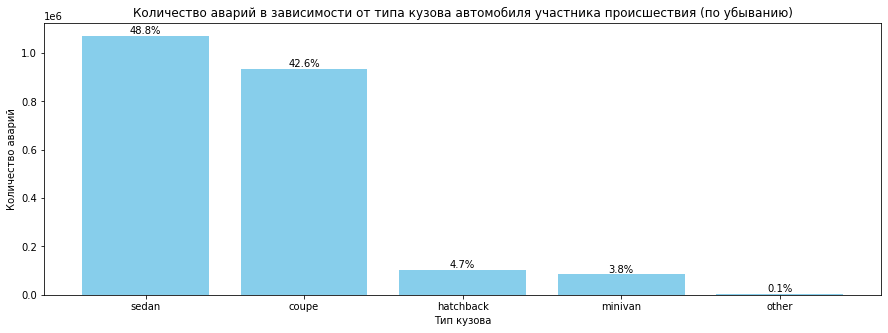

In [65]:
plot_column_distribution(vehicle_type.groupby(vehicle_type.index).sum(),
                         'count',
                         'Тип кузова',
                         'Количество аварий в зависимости от типа кузова автомобиля участника происшествия (по убыванию)')

In [66]:
result = guilt_percentage(vehicle_type)
print(result)

at_fault           0       1  guilt_percentage
vehicle_type                                  
minivan        45644   38444             45.72
coupe         516609  417917             44.72
sedan         611872  458063             42.81
hatchback      61383   41372             40.26
other           1676    1063             38.81


Из анализа данных видно, что хотя седаны и купе чаще участвуют в авариях из-за их большего числа на дорогах, вероятность попадания в аварию от типа кузова автомобиля различается, хоть и немного. Минивены имеют немного более высокий процент аварийности (45.72%), чем купе (44.72%), в то время как седаны и хэтчбеки демонстрируют более низкие показатели вероятности попадания в аварию: 42.81% и 40.26% соответственно.

#### Тип КПП

In [67]:
vehicle_transmission_query = '''
                 SELECT VEHICLE_TRANSMISSION, at_fault, COUNT(at_fault)
                 FROM parties p
                 JOIN vehicles v ON p.case_id = v.case_id
                 WHERE VEHICLE_TRANSMISSION IS NOT NULL
                 GROUP BY VEHICLE_TRANSMISSION, at_fault
                 '''

vehicle_transmission = pd.read_sql_query(vehicle_transmission_query, con=con)
#converting column to index
vehicle_transmission.set_index('vehicle_transmission', inplace=True)
vehicle_transmission

,at_fault,count
vehicle_transmission,,
auto,0,631848
auto,1,471656
manual,0,575835
manual,1,464023


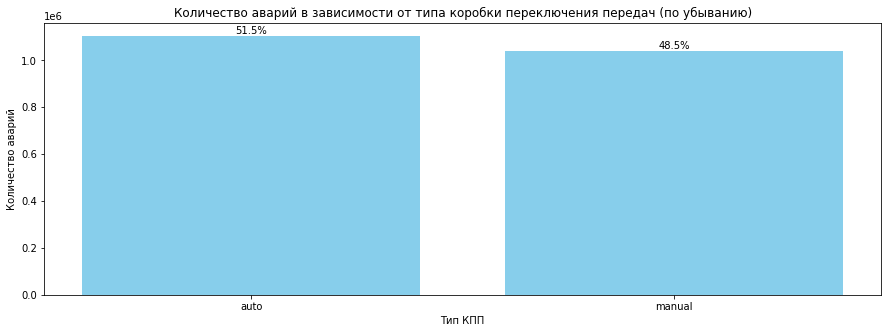

In [68]:
plot_column_distribution(vehicle_transmission.groupby(vehicle_transmission.index).sum(),
                         'count',
                         'Тип КПП',
                         'Количество аварий в зависимости от типа коробки переключения передач (по убыванию)')

In [69]:
result = guilt_percentage(vehicle_transmission)
print(result)

at_fault                   0       1  guilt_percentage
vehicle_transmission                                  
manual                575835  464023             44.62
auto                  631848  471656             42.74


Не смотря на то, что автомобили с автоматической коробкой передач участвуют в авариях в 51.5% чаще (вероятно, потому что таких машин больше), - вероятность попасть в аварию на механической коробке передач немного больше - 44.62%, в то время как с автоматической это значение 42.74% 

#### Возраст автомобиля

In [70]:
vehicle_age_query = '''
                 WITH ranked_ages AS (
                     SELECT VEHICLE_AGE,
                            at_fault,
                            ROW_NUMBER() OVER (PARTITION BY at_fault ORDER BY VEHICLE_AGE) AS rn,
                            COUNT(*) OVER (PARTITION BY at_fault) AS total_count
                     FROM parties p
                     JOIN vehicles v ON p.case_id = v.case_id
                     WHERE VEHICLE_AGE IS NOT NULL
                 )
                 SELECT ROUND(AVG(VEHICLE_AGE), 2) as avg_age,
                        at_fault,
                        AVG(VEHICLE_AGE) FILTER (WHERE rn = CEIL(total_count / 2.0)) as median_age
                 FROM ranked_ages
                 GROUP BY at_fault
                 '''

vehicle_age = pd.read_sql_query(vehicle_age_query, con=con)
vehicle_age

,avg_age,at_fault,median_age
0,5.19,0,5.0
1,5.12,1,5.0


Не видно корреляции между возрастом автомобиля и вероятностью стать виновником аварии. 

### Факторы аварии

#### Основной фактор аварии

Задача 10. Какие основные факторы аварий наиболее распространены в базе данных и с какой частотой они встречаются?

In [71]:
primary_coll_factor_query = '''
                 SELECT primary_collision_factor, at_fault, COUNT(at_fault)
                 FROM collisions c
                 JOIN parties p ON c.case_id = p.case_id
                 WHERE primary_collision_factor IS NOT NULL
                 GROUP BY primary_collision_factor, at_fault
                 '''

primary_coll_factor = pd.read_sql_query(primary_coll_factor_query, con=con)
#converting column to index
primary_coll_factor.set_index('primary_collision_factor', inplace=True)
primary_coll_factor

,at_fault,count
primary_collision_factor,,
fell asleep,0,141
fell asleep,1,47
other improper driving,0,8559
other improper driving,1,6497
other than driver,0,40885
unknown,0,71450
vehicle code violation,0,1327764
vehicle code violation,1,1281583


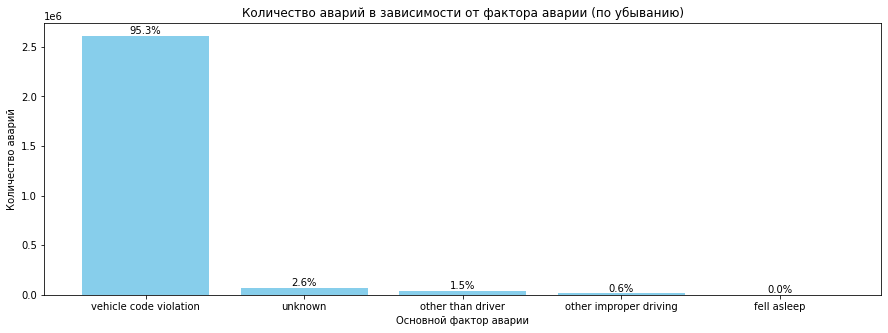

In [72]:
plot_column_distribution(primary_coll_factor.groupby(primary_coll_factor.index).sum(),
                         'count',
                         'Основной фактор аварии',
                         'Количество аварий в зависимости от фактора аварии (по убыванию)')

95.3% аварий произошли из-за нарушения правил ПДД.

#### Географический район

Задача 11. Выведите топ 8 географических районов по количеству аварий. В каких из них наиболее вероятнее стать виновником аварии?

In [73]:
county_loc_query = '''
                 SELECT COUNTY_LOCATION, at_fault, COUNT(at_fault)
                 FROM collisions c
                 JOIN parties p ON c.case_id = p.case_id
                 WHERE COUNTY_LOCATION IS NOT NULL
                 GROUP BY COUNTY_LOCATION, at_fault
                 '''

county_loc = pd.read_sql_query(county_loc_query, con=con)

In [74]:
#county_loc.sort_values(by=['count'], ascending=[False]).head(16)

In [75]:
top_county = county_loc.sort_values(by=['count'], ascending=[False]).head(16)

In [76]:
#converting column to index
top_county.set_index('county_location', inplace=True)

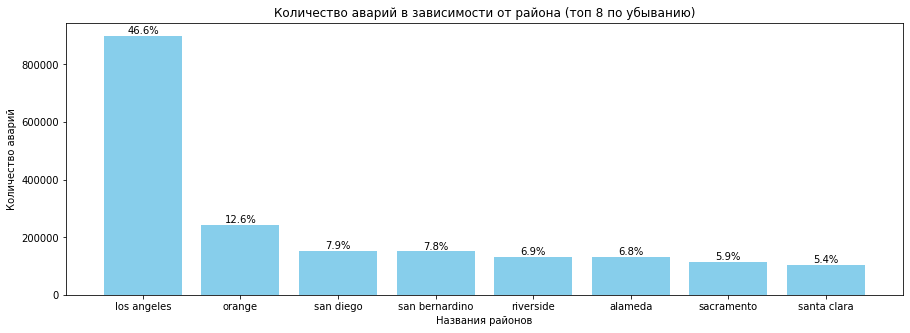

In [77]:
plot_column_distribution(top_county.groupby(top_county.index).sum(),
                         'count',
                         'Названия районов',
                         'Количество аварий в зависимости от района (топ 8 по убыванию)')

In [78]:
result = guilt_percentage(top_county)
print(result)

at_fault              0       1  guilt_percentage
county_location                                  
riverside         67842   64513             48.74
san bernardino    78567   72744             48.08
san diego         80190   73045             47.67
sacramento        61410   53193             46.42
alameda           71149   59958             45.73
santa clara       56617   46535             45.11
orange           133723  109322             44.98
los angeles      503630  395568             43.99


В Лос-Анджелесе происходит наибольшее количество аварий, однако вероятность стать виновником аварии там составляет 43.99%, что ниже, чем в следующих двух районах по распространенности - в Ориндже и Сан-Диего с вероятностями 44.98% и 47.67% соответственно.

#### Тип дороги

Задача 12. Какие категории дорог наиболее часто встречаются в базе данных аварий и какова вероятность стать виновником аварии на определенных типах дорог?

In [79]:
location_type_query = '''
                 SELECT LOCATION_TYPE, at_fault, COUNT(at_fault)
                 FROM collisions c
                 JOIN parties p ON c.case_id = p.case_id
                 WHERE LOCATION_TYPE IS NOT NULL
                 GROUP BY LOCATION_TYPE, at_fault
                 '''

location_type = pd.read_sql_query(location_type_query, con=con)
location_type.set_index('location_type', inplace=True)

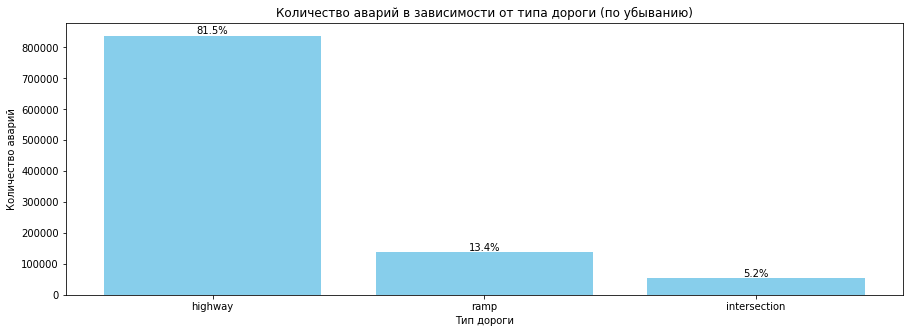

In [80]:
plot_column_distribution(location_type.groupby(location_type.index).sum(),
                         'count',
                         'Тип дороги',
                         'Количество аварий в зависимости от типа дороги (по убыванию)')

In [81]:
result = guilt_percentage(location_type)
print(result)

at_fault            0       1  guilt_percentage
location_type                                  
ramp            66546   70625             51.49
intersection    28233   24800             46.76
highway        447495  389379             46.53


Аварии чаще всего случаются на шоссе - в 81.5% случаев, реже на рампе - в 13.4%, и на перекрестке - в 5.2%. Во всех случаях вероятность стать виновником аварии практически одинакова, однако на рампе она немного выше - 51.49%, в то время как на других типах дорог вероятность ниже - менее 47%.

#### Категория нарушения 

Задача 13. Какие типы нарушений наиболее часто встречаютсяя в базе данных?

In [82]:
pcf_violation_query = '''
                 SELECT PCF_VIOLATION_CATEGORY, COUNT(PCF_VIOLATION_CATEGORY)
                 FROM collisions c
                 WHERE PCF_VIOLATION_CATEGORY IS NOT NULL
                 GROUP BY PCF_VIOLATION_CATEGORY
                 '''

pcf_violation = pd.read_sql_query(pcf_violation_query, con=con)
pcf_violation.set_index('pcf_violation_category', inplace=True)

In [83]:
pcf_violation.sort_values(by=['count'], ascending=[False]).head(3)

,count
pcf_violation_category,
speeding,438439
improper turning,238987
automobile right of way,158291


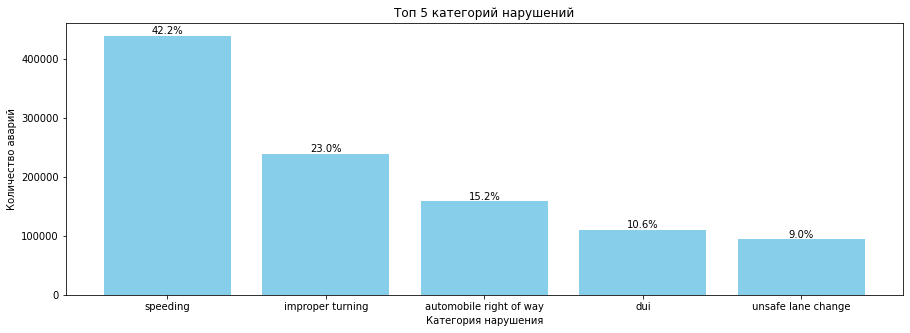

In [84]:
plot_column_distribution(pcf_violation.sort_values(by=['count'], ascending=[False]).head(5),
                         'count',
                         'Категория нарушения',
                         'Топ 5 категорий нарушений')

In [85]:
pcf_violation.sort_values(by=['count'], ascending=[False]).head(5)

,count
pcf_violation_category,
speeding,438439
improper turning,238987
automobile right of way,158291
dui,110476
unsafe lane change,93962


Самые распространенные аварии - это превышение скорости, неправильный поворот, автомобильное право проезда, небезопасная смена полосы движения. Также есть категория `dui`, вероятно, ошибочная, так как такой категории нет в исходных данных. Данные явно нуждаются в предобработке

Меня заинтересовало, в чем отличие Speeding и Unsafe Speed, и не является ли это аномалией.

**Speeding и Unsafe Speed** - это два термина, которые относятся к нарушению правил дорожного движения, связанного с превышением скорости. 

Speeding означает превышение установленного ограничения скорости на дороге. 

Unsafe Speed же означает движение с небезопасной скоростью, то есть скоростью, которая не соответствует условиям дороги, погодным условиям или другим обстоятельствам. Например, если дорога мокрая или имеются другие факторы, которые делают движение с определенной скоростью опасным, то даже если водитель не превышает установленное ограничение скорости, он все равно может быть оштрафован за Unsafe Speed.

#### Тип аварии

Задача 14. Какие типы аварий наиболее распространены в базе данных и какова вероятность стать виновником аварии при определенных типах аварий?

In [86]:
type_of_col_query = '''
                 SELECT TYPE_OF_COLLISION, at_fault, COUNT(at_fault)
                 FROM collisions c
                 JOIN parties p ON c.case_id = p.case_id
                 WHERE TYPE_OF_COLLISION IS NOT NULL
                 GROUP BY TYPE_OF_COLLISION, at_fault
                 '''

type_of_col = pd.read_sql_query(type_of_col_query, con=con)
type_of_col.set_index('type_of_collision', inplace=True)

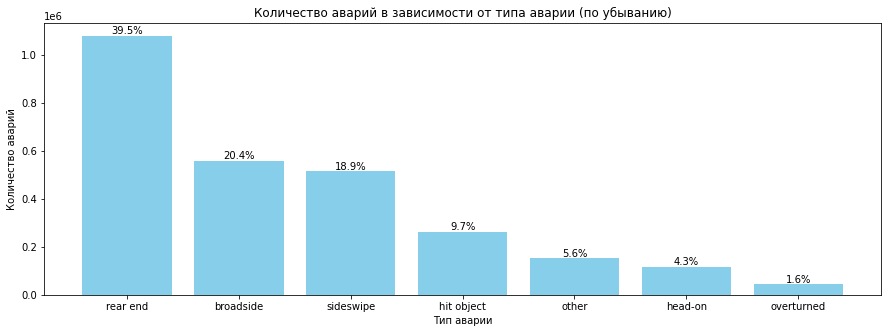

In [87]:
plot_column_distribution(type_of_col.groupby(type_of_col.index).sum(),
                         'count',
                         'Тип аварии',
                         'Количество аварий в зависимости от типа аварии (по убыванию)')

In [88]:
result = guilt_percentage(type_of_col)
print(result)

at_fault                0       1  guilt_percentage
type_of_collision                                  
overturned           6743   37422             84.73
hit object          53394  210119             79.74
head-on             62854   54902             46.62
broadside          311609  246492             44.17
other               87252   64357             42.45
rear end           629192  450359             41.72
sideswipe          300286  214660             41.69


Самые распространенные виды дорожных происшествий включают столкновение сзади (39.5%), боковой удар (20.4%) и боковое столкновение (18.9%). В этих случаях вероятность оказаться виновником аварии составляет менее 50%.

Хотя случаи аварий, связанных с опрокидыванием машины, встречаются реже - всего 1.6%, вероятность стать виновником в такой ситуации очень высока и составляет 84.73%. Также часто виновниками оказываются водители при происшествиях, связанных с ударом объекта - в 79.74% случаев.

## Выводы статистического анализа данных

После проведения статистического анализа данных об авариях можно сделать следующие выводы:

**Время:**
- Большая часть данных об авариях относится к 2009 году - 30.6%. Также имеется информация о 2010 годе - 29.8%, 2011 годе - 28.6% и 2012 годе - 11%. Доля данных о 2013 году составляет менее одного процента, а всего две записи относятся к 2020 году, что может указывать на наличие аномалии в данных.
- Большинство аварий происходит в первой половине года, с января по май (9.2-9.9%), с пиком в марте и наименьшим количеством в феврале. Во второй половине года, с июня по декабрь, доля аварий составляет 7.4-8%, с наименьшим числом случаев в июне, июле и ноябре (по 7.4%).
- Чаще всего происходят аварии по пятницам - в 16.3% случаев, в понедельник и в воскресенье вероятность наиболее низкая - 13.8% и 12.1% соответственно
- Чаще всего аварии происходят с 15 по 17 часов, что составляет 22.0% случаев, в то время как наименьшее количество аварий приходится на период с 0 до 6 утра - 13.7%.

**Серьезность повреждений:**
- Большинство аварий, а именно 90.5%, происходят на сухих дорогах, в то время как 9.0% случаев приходится на влажные дороги, 0.5% - на заснеженные и 0.1% - на грязные. Это объясняется тем, что в хорошую погоду больше людей выезжает на дороги, в то время как в плохую погоду активность снижается.

**Причины ДТП:**
- В 45.1% случаев, когда происходят аварии с участием других автомобилей, виновным оказывается клиент. Если же причиной сталы дорожные знаки, отбойник или другие факторы, клиент чаще всего остается невиновным, за исключением случаев, связанных со строениями, где вероятность вины клиента немного выше.

- Почти в половине случаев (53.9%) неизвестно состояние участника аварии. В случаях, когда состояние участника не установлено, вероятность его вины составляет 42.3%. Также видно, что наличие алкоголя в организме значительно увеличивает вероятность стать виновником аварии.

**Влияние характеристик автомобиля:**
- Хотя седаны и купе чаще участвуют в авариях из-за их распространенности на дорогах, вероятность попадания в аварию зависит от типа кузова автомобиля: минивены имеют немного более высокий процент аварийности, чем купе, в то время как седаны и хэтчбеки демонстрируют более низкие показатели вероятности попадания в аварию.

- Наблюдается небольшое различие в вероятности попадания в аварию в зависимости от типа коробки передач: автомобили с механической коробкой передач имеют чуть большую вероятность оказаться в аварии, чем те, у которых установлена автоматическая коробка передач.

- Нет явной корреляции между возрастом автомобиля и вероятностью его участия в авариях.

**Факторы аварии:**
- 95.3% аварий произошли из-за нарушения правил дорожного движения.
- В Лос-Анджелесе происходит наибольшее количество аварий, однако вероятность стать виновником аварии там составляет 43.99%, что ниже, чем в Ориндже и Сан-Диего.
- Аварии чаще всего случаются на шоссе (81.5%), реже на рампе (13.4%) и на перекрестке (5.2%). Вероятность стать виновником аварии на рампе немного выше, чем на других типах дорог.
- Самые распространенные виды дорожных происшествий включают столкновение сзади, боковой удар и боковое столкновение, где вероятность оказаться виновником составляет менее 50%.
- Случаи аварий, связанных с опрокидыванием машины и ударом объекта, имеют высокий процент виновности водителей.

# Модель для оценки водительского риска

## Подготовка набора данных 

Необходимо подготовить набор данных на основе первичного предположения заказчика:
 
- Тип виновника — только машина (car).
- Случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования взять данные только за 2012 год.

Отобрать даные, которые могут влиять на вероятность ДТП. Аргументировать свой выбор. 

**Выбор данных из таблицы collisions (информация о происшествиях):**
- Дата происшествия	COLLISION_DATE - признак нужен, так как в определенные даты может увеличиться вероятность попасть в ДТП. Было проанализированно, что в определенные месяца и дни недели вероятность выше. Также в данных может быть информация об особых датах: праздники, особые ситуации.
- Время происшествия COLLISION_TIME - проанализировано, что в некоторые часы вероятность попасть в аварию выше. Может быть добавлена информация о частых проблемах на дорогах, которые происходят в определенное время, на определенной дороге. 
- Является ли место происшествие перекрёстком INTERSECTION - в этом признаке нет необходимости, так как информация о перекрестках есть и в других признаках
- Погода WEATHER_1 - признак нужен, так как проанализирован схожий признак "состояние дороги", из которого следует, что хоть аварии зачастую происходят при ясной погоде (сухой дороге), во время дождя (влажной дороги) - стать виновником ДТП выше. 
- Серьёзность происшествия COLLISION_DAMAGE - это признак отвечает за результат аварии, исключить.
- Основной фактор аварии PRIMARY_COLL_FACTOR - исключить, этот признак невозможно предугадать.
- Состояние дороги	ROAD_SURFACE - исключить, так как данные невозможно предугадать, к тому же коррелируют с WEATHER_1
- Освещение	LIGHTING - оставить, проанализировать фактор влияния освещенности. Данные об освещенности дороги могут быть известны заранее. 
- Номер географических районов, где произошло ДТП COUNTY_CITY_LOCATION - оставить, так как проанализированно, что в некоторых районах вероятность стать виновником аварии выше. 
- Названия географических районов, где произошло ДТП COUNTY_LOCATION - исключить, так как он коррелирует с COUNTY_CITY_LOCATION
- Направление движения	DIRECTION - исключить, так как маршрут может иметь несколько направлений движений за одну поездку
- Расстояние от главной дороги (метры)	DISTANCE - оставить, проанализировать, есть ли корреляция с таргетом
- Тип дороги LOCATION_TYPE - исключить: проанализированно, что на рампе стать виновником аварии выше в среднем на 5%, чем на остальных типах дороги, но рампа состовляет 13,5% всех данных, что делает данные практически не информативными. 
- Количество участников	PARTY_COUNT - исключить, невозможно предугадать
- Категория нарушения	PCF_VIOLATION_CATEGORY - исключить, невозможно предугадать
- Тип аварии TYPE_OF_COLLISION - исключить, невозможно предугадать
- Дополнительные участники ДТП	MOTOR_VEHICLE_INVOLVED_WITH - исключить, так как по условию виновником может быть только машиина
- Дорожное состояние	ROAD_CONDITION_1 - оставить
- Устройство управления	CONTROL_CONDITION_1 - исключить, неисправный автомобиль не должен эксплуатироваться 

**Выбор данных из таблицы Parties (описание участников происшествия):**
- Номер участника происшествия PARTY_NUMBER - исключить
- Тип участника происшествия PARTY_TYPE - исключить, по условию, участник только другая машина
- Виновность участника	AT_FAULT - оставить, это таргет
- Сумма страховки (тыс. $)	INSURANCE_PREMIUM - исключить, признак из будущего
- Состояние участника: физическое или с учётом принятых лекарств	PARTY_DRUG_PHYSICAL - оставить. Под воздействием лекарств или при усталости действительно увеличивается вероятность вины участника аварии.
- Трезвость участника	PARTY_SOBRIETY - оставить, фактор трезвости предопределить можно.
- Наличие телефона в автомобиле (возможности разговаривать по громкой связи)	CELLPHONE_IN_USE - исключить, так как проанализировано, что данный фактор слабо влияет на фактор вины, и значительно больше данных, в которых не удалось определитть наличие телефона

**Vehicles (Описание автомобиля):**
- Тип кузова	VEHICLE_TYPE - исключить, так как у двух самых распространенных типов автомобилей схожая вероятность быть виновным в аварии
- Тип КПП	VEHICLE_TRANSMISSION - исключить, проанализированно, что тип КПП может повлиять, но разница менее 2%
- Возраст автомобиля (в годах)	VEHICLE_AGE - исключить, не влияет на фактор виновности

Выбранные признаки из таблицы collisions:
- COLLISION_DATE,
- COLLISION_TIME,
- WEATHER_1,
- LIGHTING,
- COUNTY_CITY_LOCATION,
- DISTANCE,
- ROAD_CONDITION_1

Выбранные признаки из таблицы Parties:
- AT_FAULT
- PARTY_DRUG_PHYSICAL
- PARTY_SOBRIETY

In [89]:
data_query = '''
                 SELECT EXTRACT(DOW FROM COLLISION_DATE) AS DAY_OF_WEEK,
                        EXTRACT(MONTH FROM COLLISION_DATE) AS MONTH,
                        DATE_PART('hour', collision_time) AS HOUR,
                        WEATHER_1,
                        LIGHTING,
                        COUNTY_CITY_LOCATION,
                        DISTANCE,
                        ROAD_CONDITION_1,
                        AT_FAULT,
                        PARTY_DRUG_PHYSICAL,
                        PARTY_SOBRIETY
                 FROM collisions c
                 JOIN parties p ON c.case_id = p.case_id
                 WHERE PARTY_TYPE = 'car'
                       AND COLLISION_DAMAGE != 'SCRATCH'
                       AND EXTRACT(YEAR FROM COLLISION_DATE) = 2012
                 '''

data = pd.read_sql_query(data_query, con=con)

In [90]:
data.head()

,day_of_week,month,hour,weather_1,lighting,county_city_location,distance,road_condition_1,at_fault,party_drug_physical,party_sobriety
0,0.0,1.0,2.0,clear,dark with street lights,0708,21.0,normal,1,None,"had been drinking, under influence"
1,5.0,1.0,15.0,clear,daylight,3313,2000.0,normal,1,G,impairment unknown
2,2.0,1.0,16.0,clear,daylight,0100,1056.0,normal,1,None,had not been drinking
3,2.0,1.0,16.0,clear,daylight,0100,1056.0,normal,0,None,had not been drinking
4,1.0,1.0,15.0,cloudy,daylight,3602,45.0,normal,1,None,had not been drinking


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273115 entries, 0 to 273114
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   day_of_week           273115 non-null  float64
 1   month                 273115 non-null  float64
 2   hour                  271701 non-null  float64
 3   weather_1             272219 non-null  object 
 4   lighting              272102 non-null  object 
 5   county_city_location  273115 non-null  object 
 6   distance              273115 non-null  float64
 7   road_condition_1      271457 non-null  object 
 8   at_fault              273115 non-null  int64  
 9   party_drug_physical   30092 non-null   object 
 10  party_sobriety        268266 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 22.9+ MB


Столбец party_drug_physical придется исключить, так как в нем слишком много пропусков. 

Столбцы day_of_week, month и hour переведу в integer.

In [92]:
#удаление столбца
data.drop('party_drug_physical', axis=1, inplace=True)

In [93]:
#Изменение типа данных 
data['day_of_week'] = data['day_of_week'].astype(int)
data['month'] = data['month'].astype(int)
#заполнение пропусков медианой 
data['hour'].fillna(data['hour'].median(), inplace=True)
data['hour'] = data['hour'].astype(int)

                                             |          | [  0%]   00:00 -> (? left)


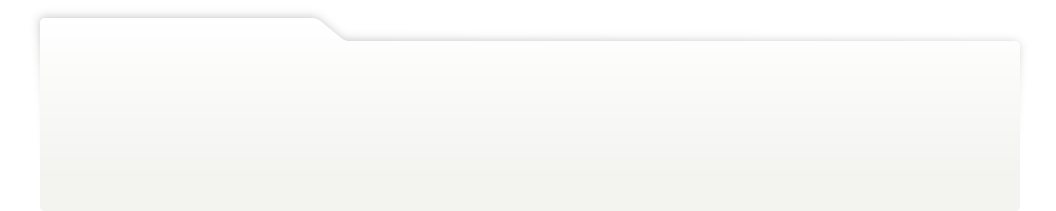
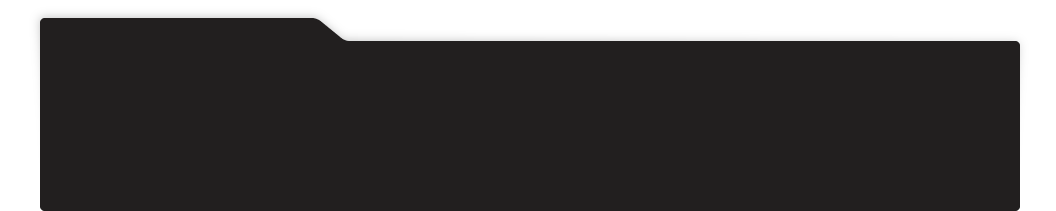
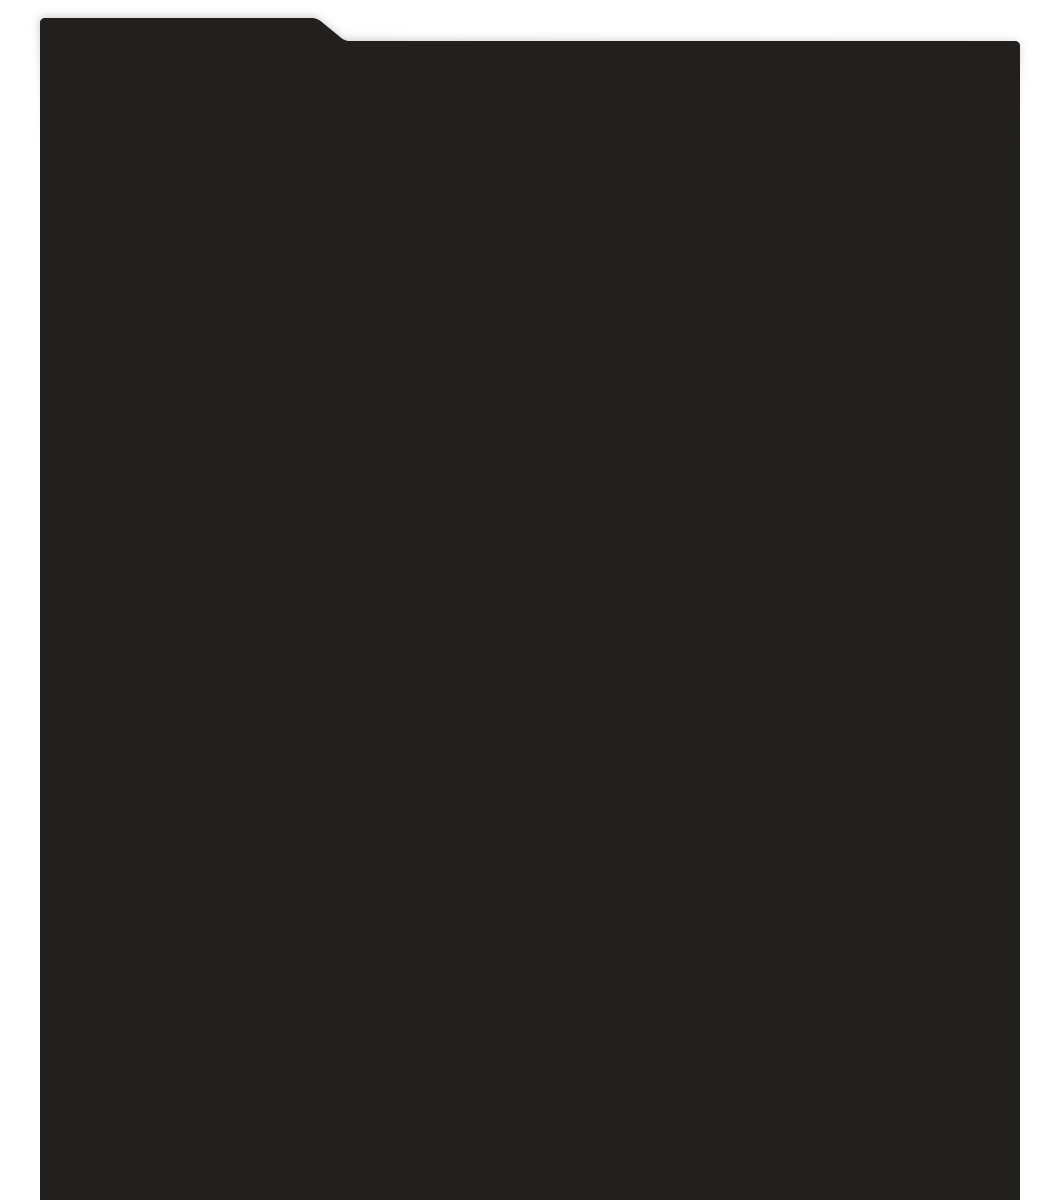
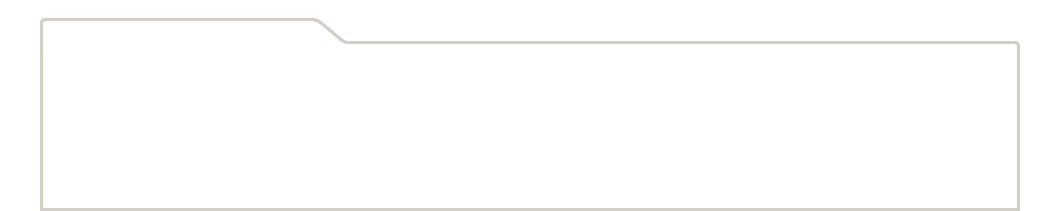
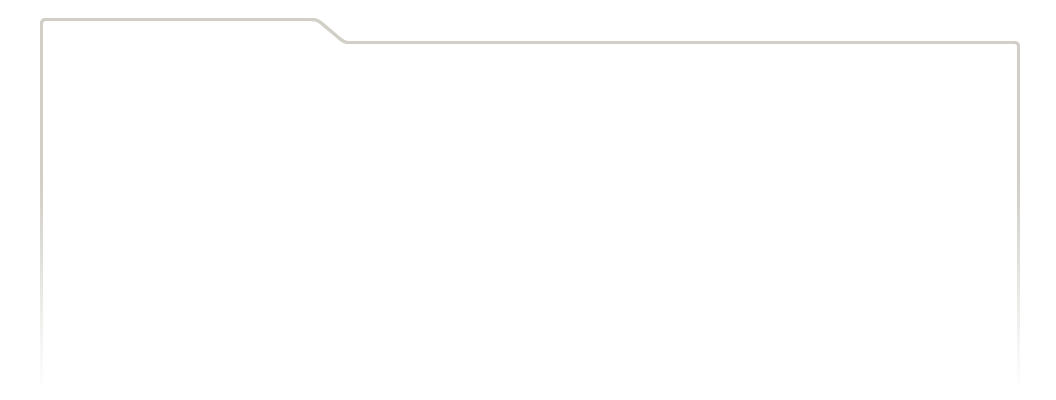
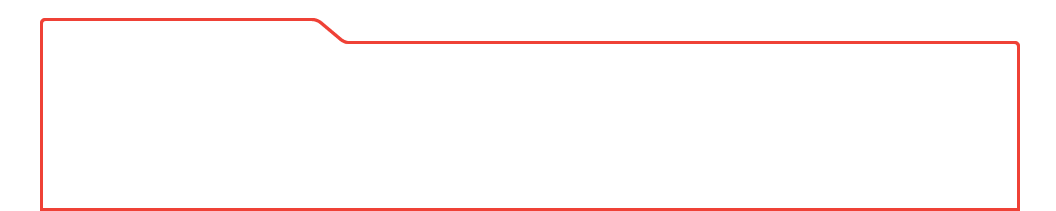
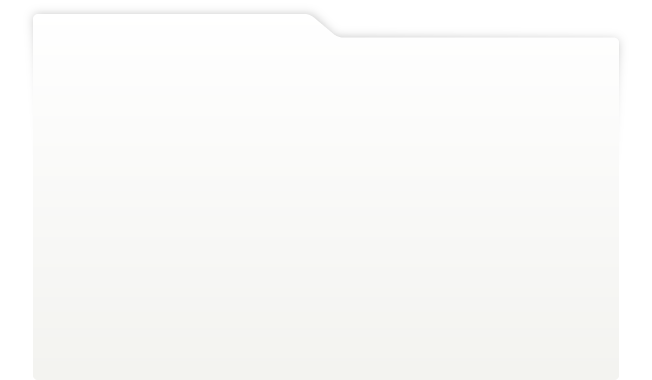
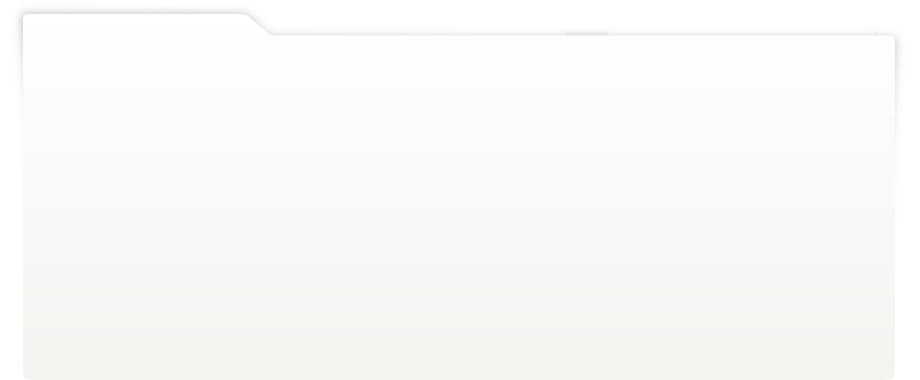
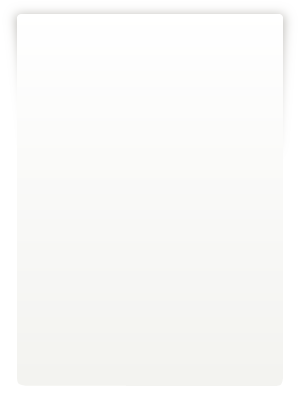
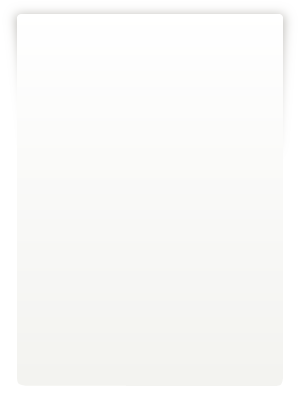
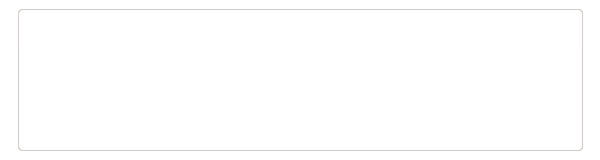
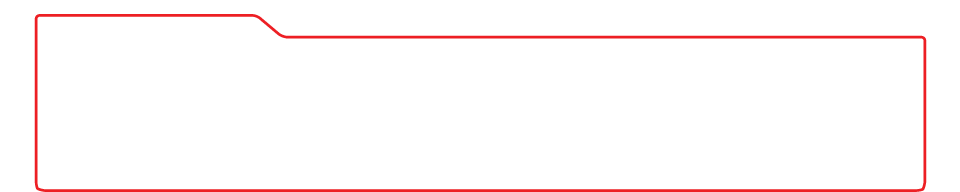
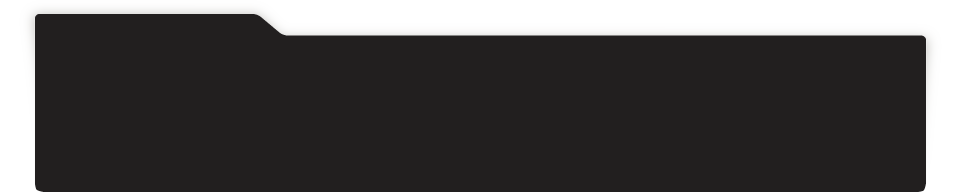
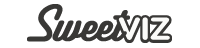
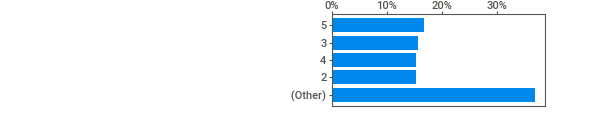
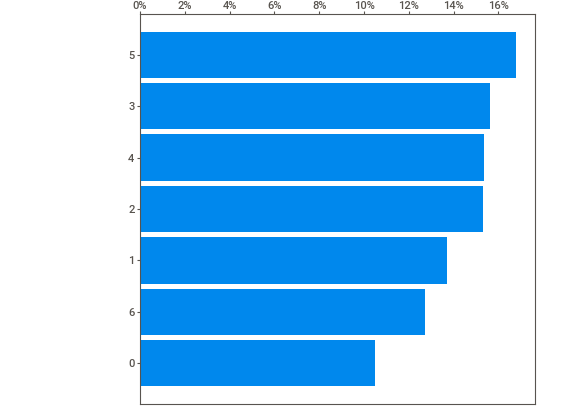
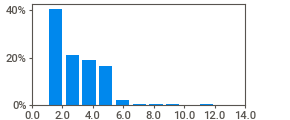
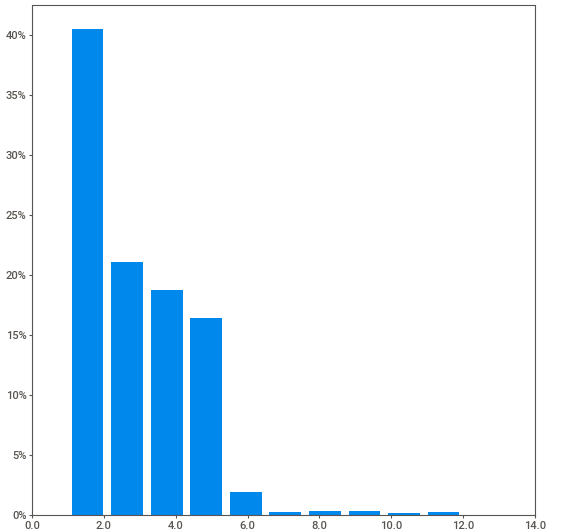
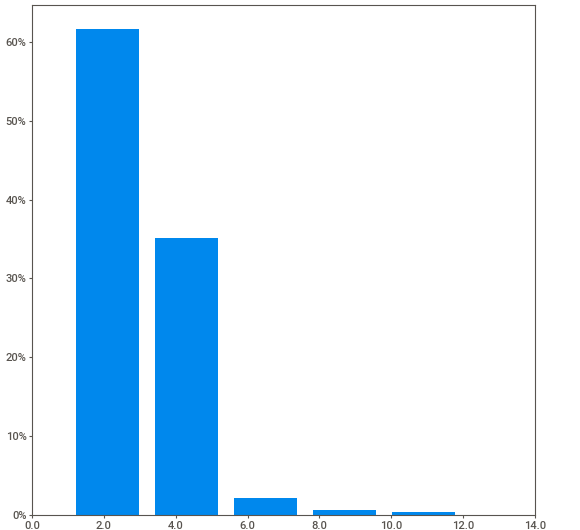
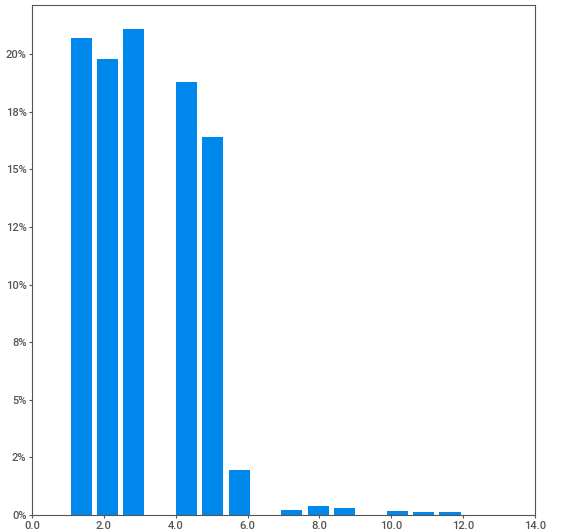
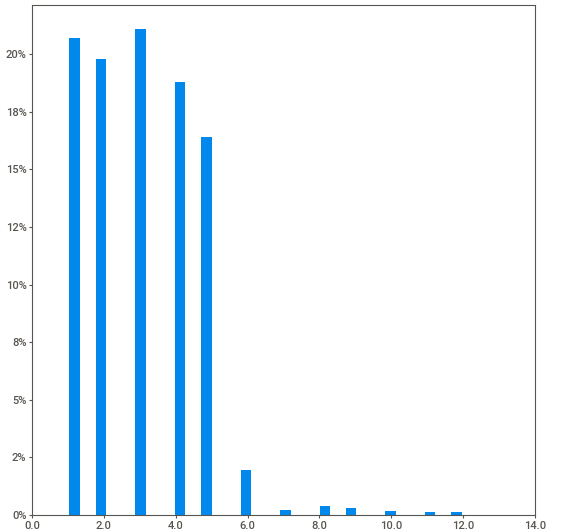
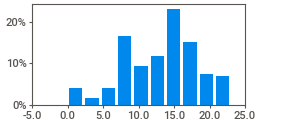
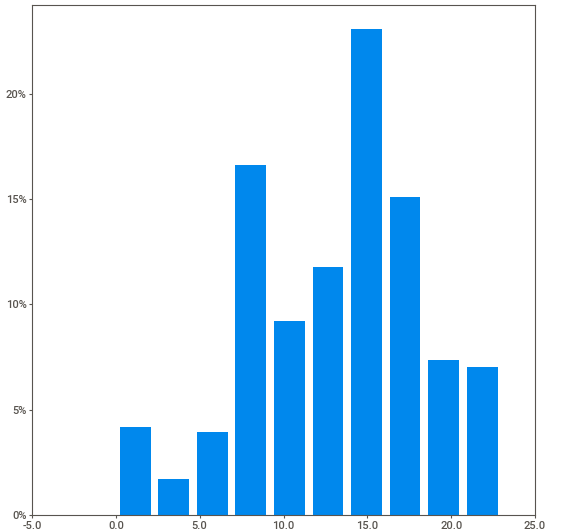
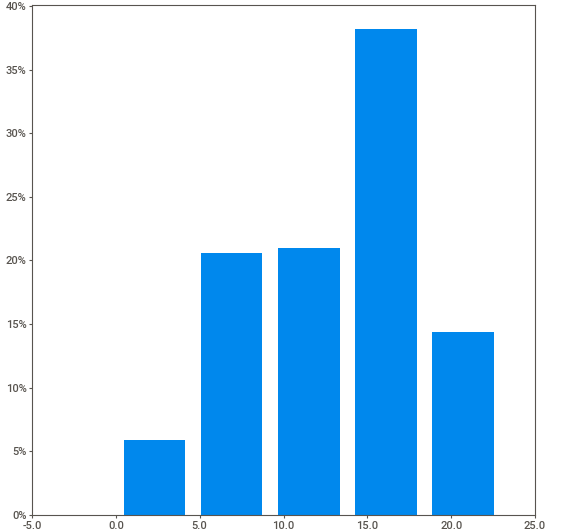
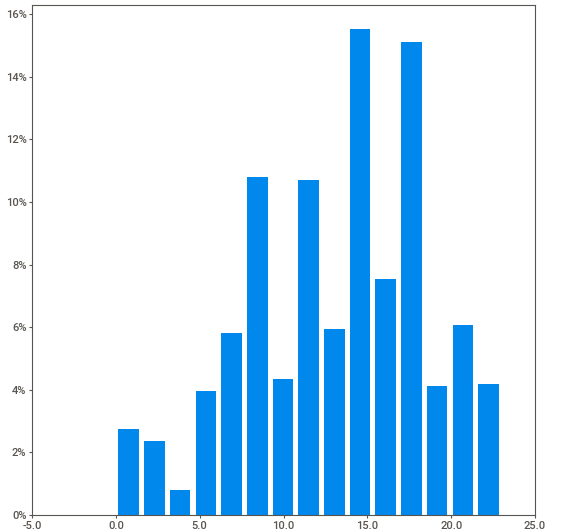
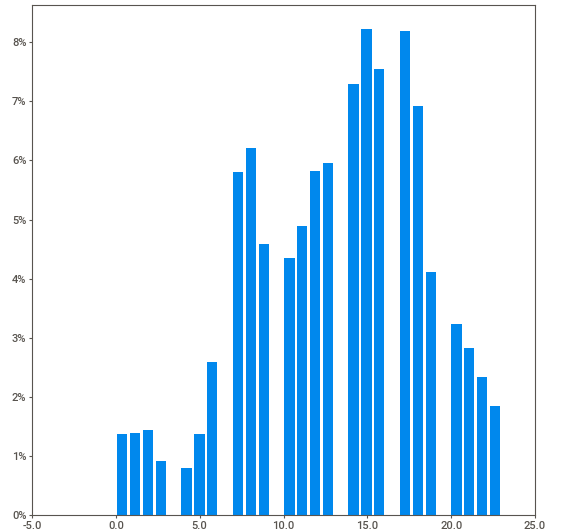
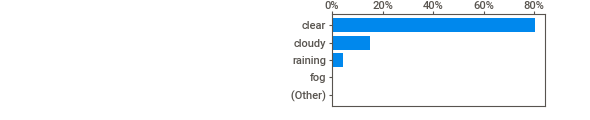
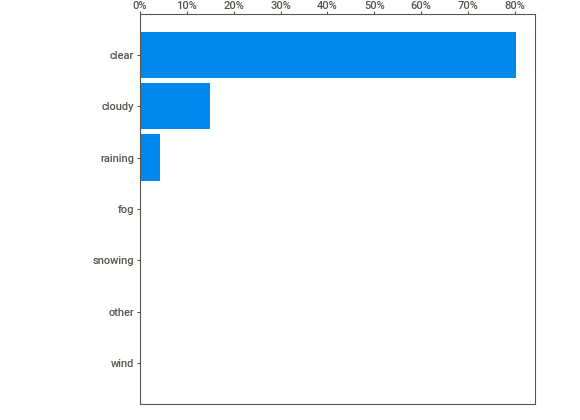
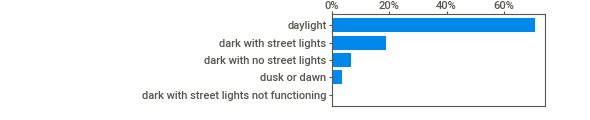
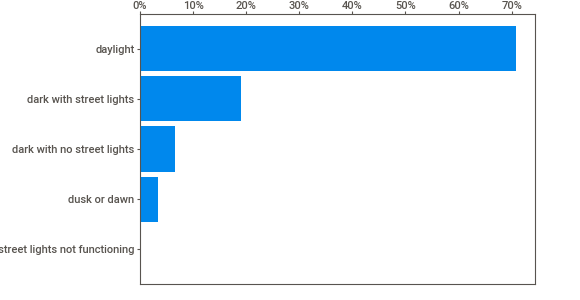
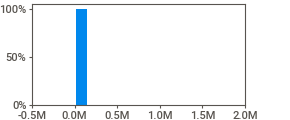
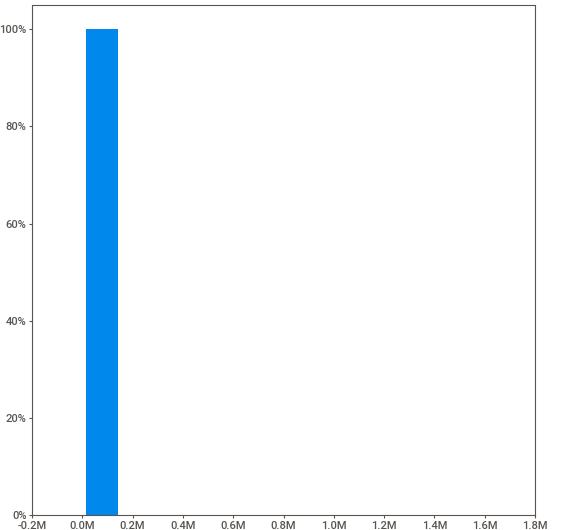
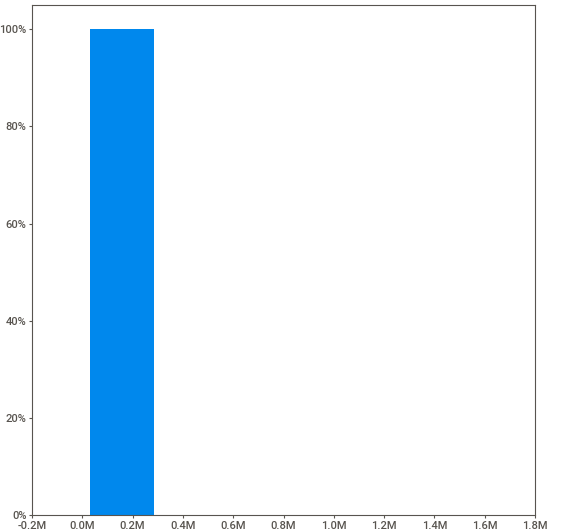
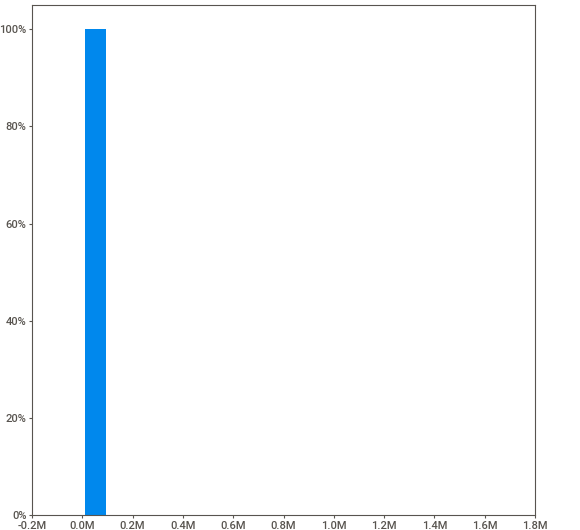
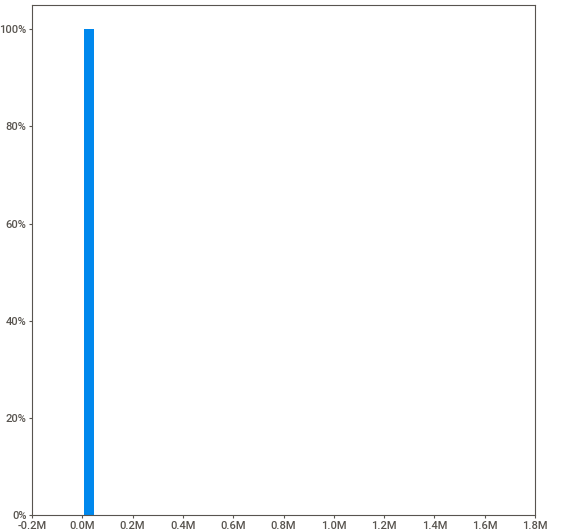
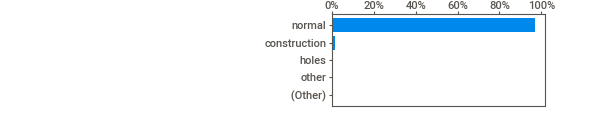
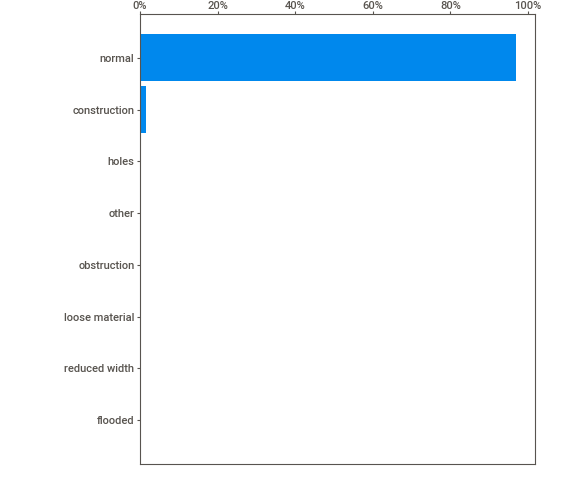
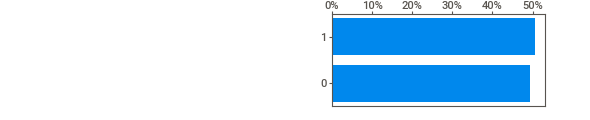
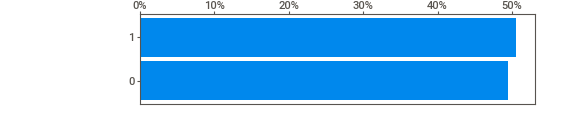
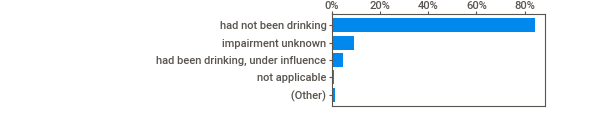
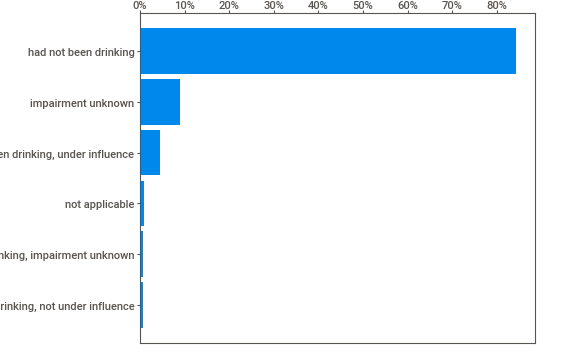
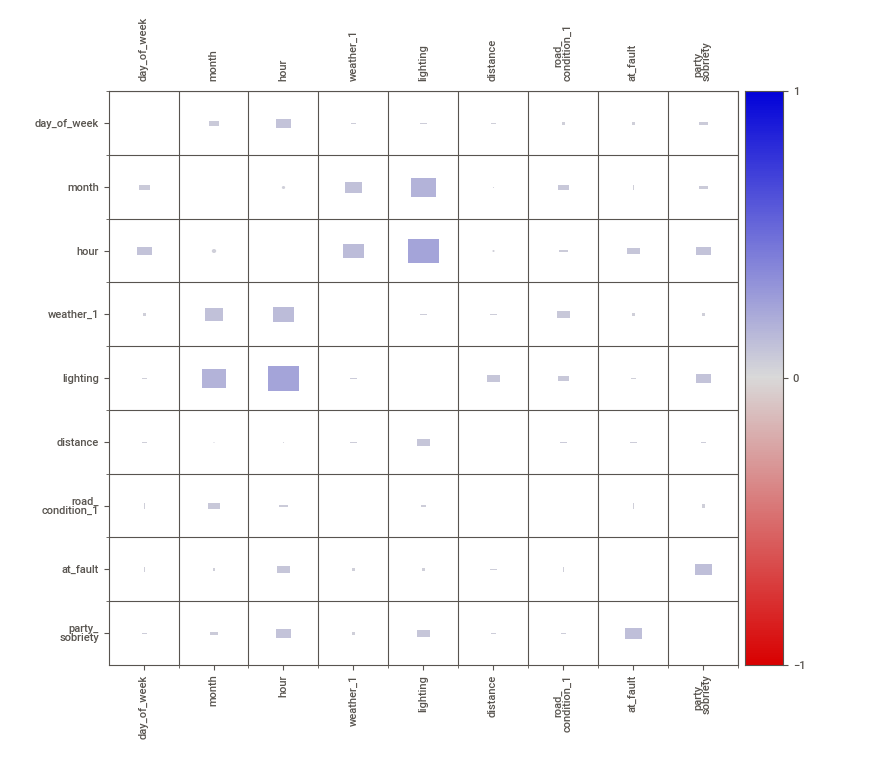
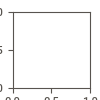

In [94]:
my_report = sv.analyze(data)
my_report.show_notebook(scale=0.8)

- В основном, данные об авариях за первую половину года. 
- Распределение аварий по дням недели и часам соответствует распределению по данным из первичной таблицы.
- В lighting один из признаков имеет слишком мало значений, также нужно проанализировать его связь с таргетом.
- county_city_location имеет 516 уникальных значений, оставлю лишь самые распространенные 
- признак distance необходимо проанализировать подробнее. 
- 97% данных в road_condition_1 относятся к одной категории, данный признак необходимо исключить
- признак at_fault распредел сбалансированно: распределение 1 и 0 - 51% и 49% соответственно
- в признаке party_sobriety, необходимо сократить количество признаков
- в признаке weather_1 есть категории, в которых практически нет значений, нужен дополнительный анализ

## Предобработка и анализ отобранных данных 

### lighting

In [95]:
data['lighting'].value_counts(normalize=True)

daylight                                   0.708532
dark with street lights                    0.189638
dark with no street lights                 0.065560
dusk or dawn                               0.034090
dark with street lights not functioning    0.002179
Name: lighting, dtype: float64

Объединю категории 'dark with no street lights' и 'dark with street lights not functioning' - с точки зрения водителя, категории объясняют одну и ту же ситуацию.

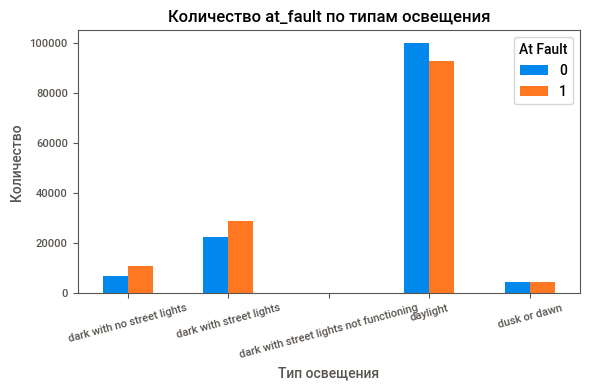

In [96]:
grouped = data.groupby(['lighting', 'at_fault']).size().unstack(fill_value=0)

# Строим столбчатую диаграмму
grouped.plot(kind='bar', stacked=False)
plt.title('Количество at_fault по типам освещения')
plt.xlabel('Тип освещения')
plt.ylabel('Количество')
plt.xticks(rotation=15)
plt.legend(title='At Fault')
plt.tight_layout()

# Показываем график
plt.show()

В темноте действительно выше шанс стать виновником аварии

### county_city_location

In [97]:
data['county_city_location'].value_counts(normalize=True).head(10)

1942    0.131556
1900    0.034139
3711    0.023309
3400    0.018571
4313    0.018322
1941    0.014730
3001    0.014715
3404    0.012954
1500    0.012749
0109    0.012401
Name: county_city_location, dtype: float64

In [98]:
#Оставлю 5 первых значений
values_to_keep = ['1942', '1900', '3711', '3400', '4313']
counts = data['county_city_location'].value_counts()

# Замена значений
data['county_city_location'] = data['county_city_location'].where(
    (data['county_city_location'].isin(values_to_keep)),'other')

In [99]:
#проверка
data['county_city_location'].value_counts()

other    211419
1942      35930
1900       9324
3711       6366
3400       5072
4313       5004
Name: county_city_location, dtype: int64

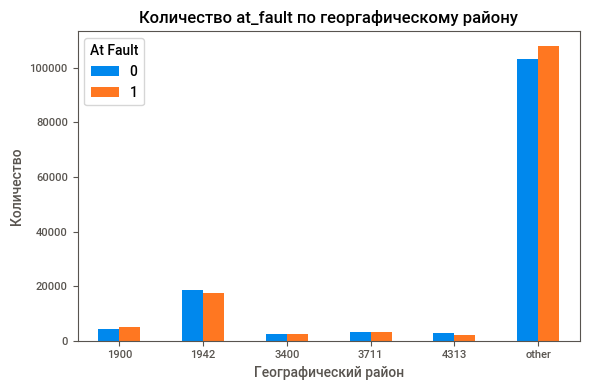

In [100]:
grouped = data.groupby(['county_city_location', 'at_fault']).size().unstack(fill_value=0)

# Строим столбчатую диаграмму
grouped.plot(kind='bar', stacked=False)
plt.title('Количество at_fault по георгафическому району')
plt.xlabel('Географический район')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(title='At Fault')
plt.tight_layout()

# Показываем график
plt.show()

### distance

In [101]:
data['distance'].value_counts(normalize=True).head(5)

0.0      0.244922
100.0    0.038288
200.0    0.031939
300.0    0.026439
50.0     0.025996
Name: distance, dtype: float64

Сделаю данный признак булевым: либо на главном шоссе, либо нет.

In [102]:
# Переименовывание столбца
data.rename(columns={'distance': 'on_main_road'}, inplace=True)

# Замена численных значений на булевые
data['on_main_road'] = data['on_main_road'] == 0

In [103]:
#проверка
data['on_main_road'].value_counts(normalize=True)

False    0.755078
True     0.244922
Name: on_main_road, dtype: float64

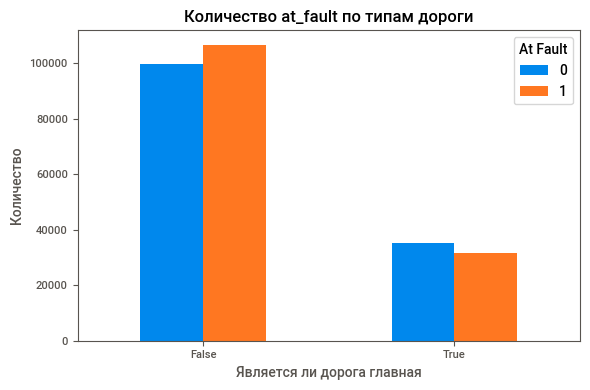

In [104]:
grouped = data.groupby(['on_main_road', 'at_fault']).size().unstack(fill_value=0)

# Строим столбчатую диаграмму
grouped.plot(kind='bar', stacked=False)
plt.title('Количество at_fault по типам дороги')
plt.xlabel('Является ли дорога главная')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(title='At Fault')
plt.tight_layout()

# Показываем график
plt.show()

Вероятность стать виновником аварии, если она не на главной дороге - выше.

### road_condition_1

In [105]:
#удаление столбца
#97% данных в road_condition_1 относятся к одной категории
data.drop('road_condition_1', axis=1, inplace=True)

### party_sobriety

In [106]:
data['party_sobriety'].value_counts(normalize=True)

had not been drinking                     0.843014
impairment unknown                        0.089803
had been drinking, under influence        0.044665
not applicable                            0.008734
had been drinking, impairment unknown     0.007343
had been drinking, not under influence    0.006441
Name: party_sobriety, dtype: float64

Значения "impairment unknown" и "not applicable" описывают состояние участника в аварии. При этом "impairment unknown" означает отсутствие достаточных данных для оценки состояния, в то время как "not applicable" обозначает, что оценка состояния не требуется в данной ситуации.

Я планирую объединить эти категории в одну под названием 'unknown', поскольку для целей моделирования исходов аварий они обладают аналогичными характеристиками.

Также я собираюсь объединить значения "had been drinking, under influence", "had been drinking, impairment unknown", "had been drinking, not under influence" под общим термином "had been drinking".

In [107]:
# Замена значений в столбце 'party_sobriety'
data['party_sobriety'] = data['party_sobriety'].replace({
    'impairment unknown': 'unknown',
    'not applicable': 'unknown',
    'had been drinking, under influence': 'had been drinking',
    'had been drinking, impairment unknown': 'had been drinking',
    'had been drinking, not under influence': 'had been drinking'
})

In [108]:
#проверка
data['party_sobriety'].value_counts(normalize=True)

had not been drinking    0.843014
unknown                  0.098537
had been drinking        0.058449
Name: party_sobriety, dtype: float64

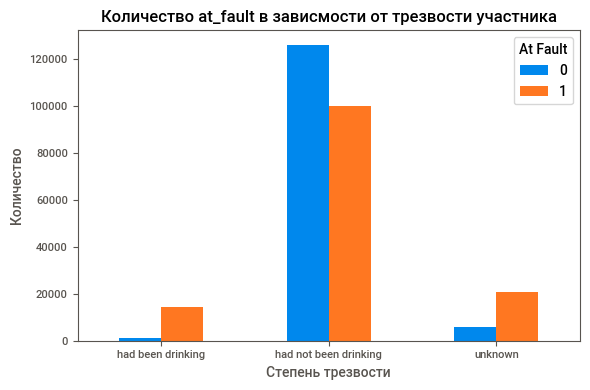

In [109]:
grouped = data.groupby(['party_sobriety', 'at_fault']).size().unstack(fill_value=0)

# Строим столбчатую диаграмму
grouped.plot(kind='bar', stacked=False)
plt.title('Количество at_fault в зависмости от трезвости участника')
plt.xlabel('Степень трезвости')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(title='At Fault')
plt.tight_layout()

# Показываем график
plt.show()

Видно по графику, что когда неизвестно состояние участника или он точно пьян, то вероятность его вины в аварии возрастает.

### weather_1

In [110]:
data['weather_1'].value_counts(normalize=True)

clear      0.802670
cloudy     0.149486
raining    0.041867
fog        0.002965
snowing    0.001940
other      0.000816
wind       0.000257
Name: weather_1, dtype: float64

In [111]:
#Объединю значения fog, snowing, wind с other
# Замена значений в столбце ''weather_1'
data['weather_1'] = data['weather_1'].replace({
    'fog': 'other',
    'snowing': 'other',
    'wind': 'other'
})

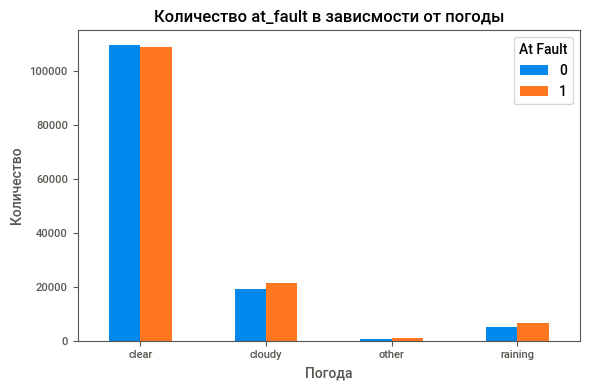

In [112]:
grouped = data.groupby(['weather_1', 'at_fault']).size().unstack(fill_value=0)

# Строим столбчатую диаграмму
grouped.plot(kind='bar', stacked=False)
plt.title('Количество at_fault в зависмости от погоды')
plt.xlabel('Погода')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(title='At Fault')
plt.tight_layout()

# Показываем график
plt.show()

Когда погода не ясная, вероятность быть виновником аварии чуть выше.

### Общая обработка

In [113]:
# Заполнение пропусков наиболее распространенными значениями

data['weather_1'].fillna(data['weather_1'].mode()[0], inplace=True)
data['lighting'].fillna(data['lighting'].mode()[0], inplace=True)
data['party_sobriety'].fillna(data['party_sobriety'].mode()[0], inplace=True)

In [114]:
# проверка на наличие дубликатов
data.duplicated().sum()

221794

In [115]:
# Удаление дупликатов
data = data.drop_duplicates()

### Вывод по предобработке данных

In [116]:
data.head()

,day_of_week,month,hour,weather_1,lighting,county_city_location,on_main_road,at_fault,party_sobriety
0,0,1,2,clear,dark with street lights,other,False,1,had been drinking
1,5,1,15,clear,daylight,other,False,1,unknown
2,2,1,16,clear,daylight,other,False,1,had not been drinking
3,2,1,16,clear,daylight,other,False,0,had not been drinking
4,1,1,15,cloudy,daylight,other,False,1,had not been drinking


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51321 entries, 0 to 273097
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   day_of_week           51321 non-null  int64 
 1   month                 51321 non-null  int64 
 2   hour                  51321 non-null  int64 
 3   weather_1             51321 non-null  object
 4   lighting              51321 non-null  object
 5   county_city_location  51321 non-null  object
 6   on_main_road          51321 non-null  bool  
 7   at_fault              51321 non-null  int64 
 8   party_sobriety        51321 non-null  object
dtypes: bool(1), int64(4), object(4)
memory usage: 3.6+ MB


In [118]:
data['at_fault'].value_counts()

1    30427
0    20894
Name: at_fault, dtype: int64

После удаления дубликатов появился дисбаланс классов

**Проанализировано:**
- В основном данные об авариях за первую половину года.
- Распределение аварий по дням недели и часам соответствует распределению из первичной таблицы.
- Признак at_fault распределен сбалансированно: распределение 1 и 0 составляет 51% и 49% соответственно.
- Изначально отобранные признаки party_drug_physical и road_condition_1 удалены. Первый — из-за большого количества пропусков в данных, второй — из-за того, что 97% данных относятся к одной категории, что делает признак неинформативным.
- В темное время суток шанс стать виновником аварии выше.
- Вероятность стать виновником аварии на второстепенной дороге выше.
- Когда состояние участника неизвестно или он точно пьян, вероятность его вины в аварии возрастает.
- Когда погода не ясная, вероятность быть виновником аварии чуть выше.

**Обработка данных:**
- В столбце lighting объединены категории 'dark with no street lights' и 'dark with street lights not functioning', так как с точки зрения водителя, категории объясняют одну и ту же ситуацию.
- В столбце county_city_location я оставила первые пять значений, а остальные объединила в other.
- Из численного признака distance я создала булев признак, обозначив присутствие на главной дороге как True.
- Значения "impairment unknown" и "not applicable" объединены в категорию 'unknown'. Также объединены значения "had been drinking, under influence", "had been drinking, impairment unknown", "had been drinking, not under influence" под общим термином "had been drinking".
- В столбце weather1 категории fog, snowing, wind объединены с other.
- Проведена проверка на наличие дубликатов.
- Пропуски заполнены медианными значениями.

## Подготовка обучающей и тестовой выборки

In [119]:
X = data.drop(columns={'at_fault'})
y = data['at_fault']

X.head()

,day_of_week,month,hour,weather_1,lighting,county_city_location,on_main_road,party_sobriety
0,0,1,2,clear,dark with street lights,other,False,had been drinking
1,5,1,15,clear,daylight,other,False,unknown
2,2,1,16,clear,daylight,other,False,had not been drinking
3,2,1,16,clear,daylight,other,False,had not been drinking
4,1,1,15,cloudy,daylight,other,False,had not been drinking


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=12345,
                                                    shuffle=True,
                                                    stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(38490, 8) (12831, 8) (38490,) (12831,)


In [121]:
X_train.columns

Index(['day_of_week', 'month', 'hour', 'weather_1', 'lighting',
       'county_city_location', 'on_main_road', 'party_sobriety'],
      dtype='object')

In [ ]:
columns_to_convert = ['weather_1', 'lighting', 'county_city_location', 'on_main_road', 'party_sobriety']
X_train[columns_to_convert] = X_train[columns_to_convert].astype('category')

#Определение списка столбцов категориальных и числовых данных в обучающем наборе X_train.
cat_col = X_train.select_dtypes(include='category').columns.tolist()
num_col = X_train.select_dtypes(include='number').columns.tolist()

print('cat_columns:', cat_col,
      'num_columns:', num_col)

#кодирование для RandomForestClassifier
num_pipeline = make_pipeline(StandardScaler())

column_transformer_forest = make_column_transformer(
    (num_pipeline, num_col),
    (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_col)
)

In [122]:
#кодирование для бустинговых моделей
num_pipeline = make_pipeline(StandardScaler())

column_transformer_boost = make_column_transformer(
    (num_pipeline, num_col)
)

cat_columns: ['weather_1', 'lighting', 'county_city_location', 'on_main_road', 'party_sobriety'] num_columns: ['day_of_week', 'month', 'hour']


In [123]:
#проверка
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38490 entries, 142087 to 15977
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   day_of_week           38490 non-null  int64   
 1   month                 38490 non-null  int64   
 2   hour                  38490 non-null  int64   
 3   weather_1             38490 non-null  category
 4   lighting              38490 non-null  category
 5   county_city_location  38490 non-null  category
 6   on_main_road          38490 non-null  category
 7   party_sobriety        38490 non-null  category
dtypes: category(5), int64(3)
memory usage: 1.4 MB


## Поиск лучшей модели

**Будут созданы три модели: RandomForestClassifier, CatBoostClassifier и LGBMClassifier. Каждая с перебором гиперпараметров.**

Расчет моделей будет происходить как с применением SMOTETomek, так и с балансировкой классов с помощью гиперпараметров. 


В качестве метрики применяется average_precision.Использование метрики average_precision позволяет более точно оценить, насколько хорошо модель способна выявлять редкие, но критически важные случаи, минимизируя при этом риск пропуска важных событий и перекос в сторону более частых, но менее значимых классификаций. Это делает average_precision особенно подходящей для задач, где точность каждого отдельного предсказания имеет большое значение.

### Создание pipeline с SMOTETomek() 

In [124]:
# для RandomForestClassifier
pipeline_forest_sm = make_pipeline(
    column_transformer_forest,
    SMOTETomek(),
    RandomForestClassifier(random_state=12345))
pipeline_forest_sm.named_steps

{'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  ['day_of_week', 'month', 'hour']),
                                 ('onehotencoder',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['weather_1', 'lighting',
                                   'county_city_location', 'on_main_road',
                                   'party_sobriety'])]),
 'smotetomek': SMOTETomek(),
 'randomforestclassifier': RandomForestClassifier(random_state=12345)}

In [125]:
# для бустингов
pipeline_boost_sm = make_pipeline(
    column_transformer_boost,
    SMOTETomek(),
    LGBMClassifier(random_state=12345)
)

pipeline_boost_sm.steps[-1] = ('model', pipeline_boost_sm.steps[-1][1])
pipeline_boost_sm.named_steps

{'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  ['day_of_week', 'month', 'hour'])]),
 'smotetomek': SMOTETomek(),
 'model': LGBMClassifier(random_state=12345)}

### Создание pipeline с использованием  гиперпараметров для балансировки классов

In [126]:
# для RandomForestClassifier
pipeline_forest = make_pipeline(
    column_transformer_forest,
    RandomForestClassifier(random_state=12345, class_weight='balanced')
)
pipeline_forest.named_steps

{'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  ['day_of_week', 'month', 'hour']),
                                 ('onehotencoder',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['weather_1', 'lighting',
                                   'county_city_location', 'on_main_road',
                                   'party_sobriety'])]),
 'randomforestclassifier': RandomForestClassifier(class_weight='balanced', random_state=12345)}

In [127]:
# для бустингов
pipeline_boost = make_pipeline(
    column_transformer_boost,
    LGBMClassifier(random_state=12345)
)

pipeline_boost.steps[-1] = ('model', pipeline_boost.steps[-1][1])
pipeline_boost.named_steps

{'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  ['day_of_week', 'month', 'hour'])]),
 'model': LGBMClassifier(random_state=12345)}

### Обучение моделей c использованием SMOTETomek()

#### Модели с бустинговым алгоритмом

In [128]:
# Определение параметров для моделей c pipeline_boost
params = [
    {
        'model': [LGBMClassifier(random_state=12345)],
        'model__n_estimators': [50, 100, 150],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [4, 6, 8]
    },
    {
        'model': [CatBoostClassifier(random_state=12345, verbose=0)],
        'model__iterations': [50, 100, 150],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__depth': [4, 6, 8]
    }
]


# Настройка GridSearchCV
grid = GridSearchCV(
    pipeline_boost_sm,
    params,
    cv=3,
    verbose=5,
    scoring='average_precision',
    n_jobs=-1
)

# Обучение модели
grid.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END model=LGBMClassifier(random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50;, score=0.626 total time=   1.1s
[CV 2/3] END model=LGBMClassifier(random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50;, score=0.628 total time=   0.8s
[CV 3/3] END model=LGBMClassifier(random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50;, score=0.621 total time=   1.2s
[CV 1/3] END model=LGBMClassifier(random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=100;, score=0.630 total time=   1.9s
[CV 2/3] END model=LGBMClassifier(random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=100;, score=0.633 total time=   1.5s
[CV 3/3] END model=LGBMClassifier(random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=100;, score=0.626 total 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['day_of_week',
                                                                          'month',
                                                                          'hour'])])),
                                       ('smotetomek', SMOTETomek()),
                                       ('model',
                                        LGBMClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [LGBMClassifier(random_state=12345)],
                          'model__learning_rate': [0.01, 0.1, 0.2],
                          'model__max_depth': [4, 6, 8],
                          'model__n_estimators': [50, 100, 150]},
                         {'model': [<catboost.core.CatBoostClassifier object at 0x7ff0f9c74460>],
                          'model__depth': [4, 6, 8],
                          'model__iterations': [50, 100, 150],
                          'model__learning_rate': [0.01, 0.1, 0.2]}],
             scoring='average_precision', verbose=5)

In [129]:
best_models_boost_sm = results()
best_models_boost_sm.index = ['smote_tomek'] * 2
best_models_boost_sm

,model_name,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__iterations,param_model__depth,mean_fit_time,mean_score_time,mean_test_score
smote_tomek,LGBMClassifier,50.0,0.1,4.0,NaN,NaN,0.70,0.10,0.63
smote_tomek,CatBoostClassifier,NaN,0.2,NaN,50.0,6.0,0.82,0.01,0.63


#### RandomForestClassifier

In [130]:
# Определение параметров для RandomForestClassifier
params = [
    {
        'randomforestclassifier__n_estimators': [50, 100, 150],
        'randomforestclassifier__max_depth': [4, 6, 8],
        'randomforestclassifier__min_samples_split': [2, 5, 10]
    }
]


# Настройка GridSearchCV
grid = GridSearchCV(
    pipeline_forest_sm,
    params,
    cv=3,
    verbose=5,
    scoring='average_precision',
    n_jobs=-1
)

# Обучение модели
grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.740 total time=   5.6s
[CV 2/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.732 total time=   5.4s
[CV 3/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.736 total time=   5.5s
[CV 1/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100;, score=0.741 total time=   5.8s
[CV 2/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100;, score=0.731 total time=   5.8s
[CV 3/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, ra

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['day_of_week',
                                                                          'month',
                                                                          'hour']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['weather_1',
                                                                          'lighting',
                                                                          'county_city_location',
                                                                          'on_main_road',
                                                                          'party_sobriety'])])),
                                       ('smotetomek', SMOTETomek()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'randomforestclassifier__max_depth': [4, 6, 8],
                          'randomforestclassifier__min_samples_split': [2, 5,
                                                                        10],
                          'randomforestclassifier__n_estimators': [50, 100,
                                                                   150]}],
             scoring='average_precision', verbose=5)

In [131]:
# Вывод результатов лучшей модели RandomForest
best_rf_model_sm = best_random_forest_model(grid)
best_rf_model_sm['model_name'] = 'RandomForestClassifier'
cols = best_rf_model_sm.columns.tolist()
cols = ['model_name'] + [col for col in cols if col != 'model_name']
best_rf_model_sm = best_rf_model_sm.reindex(columns=cols)
best_rf_model_sm.index = ['smote_tomek']
best_rf_model_sm

,model_name,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_split,mean_fit_time,mean_score_time,mean_test_score
smote_tomek,RandomForestClassifier,100,6,10,5.87,0.09,0.74


### Обучение моделей без SMOTETomek()

#### Модели с бустинговым алгоритмом

In [132]:
# Определение параметров для моделей c pipeline_boost
params = [
    {
        'model': [LGBMClassifier(random_state=12345, class_weight='balanced')],
        'model__n_estimators': [50, 100, 150],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [4, 6, 8]
    },
    {
        'model': [CatBoostClassifier(random_state=12345, verbose=0, class_weights = [0.6864, 1])],
        'model__iterations': [50, 100, 150],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__depth': [4, 6, 8]
    }
]


# Настройка GridSearchCV
grid = GridSearchCV(
    pipeline_boost,
    params,
    cv=3,
    verbose=5,
    scoring='average_precision',
    n_jobs=-1
)

# Обучение модели
grid.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END model=LGBMClassifier(class_weight='balanced', random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50;, score=0.629 total time=   0.4s
[CV 2/3] END model=LGBMClassifier(class_weight='balanced', random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50;, score=0.630 total time=   1.0s
[CV 3/3] END model=LGBMClassifier(class_weight='balanced', random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50;, score=0.622 total time=   0.8s
[CV 1/3] END model=LGBMClassifier(class_weight='balanced', random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=100;, score=0.628 total time=   1.6s
[CV 2/3] END model=LGBMClassifier(class_weight='balanced', random_state=12345), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=100;, score=0.632 total time=   1.0s
[CV 3/3] END model=LG

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['day_of_week',
                                                                          'month',
                                                                          'hour'])])),
                                       ('model',
                                        LGBMClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [LGBMClassifier(class_weight='balanced',
                                                   random_state=12345)],
                          'model__learning_rate': [0.01, 0.1, 0.2],
                          'model__max_depth': [4, 6, 8],
                          'model__n_estimators': [50, 100, 150]},
                         {'model': [<catboost.core.CatBoostClassifier object at 0x7ff0f9c732b0>],
                          'model__depth': [4, 6, 8],
                          'model__iterations': [50, 100, 150],
                          'model__learning_rate': [0.01, 0.1, 0.2]}],
             scoring='average_precision', verbose=5)

In [133]:
best_models_boost = results()
best_models_boost.index = ['balanced'] * 2
best_models_boost

,model_name,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__iterations,param_model__depth,mean_fit_time,mean_score_time,mean_test_score
balanced,LGBMClassifier,50.0,0.1,4.0,NaN,NaN,0.56,0.10,0.63
balanced,CatBoostClassifier,NaN,0.1,NaN,50.0,4.0,0.52,0.01,0.63


#### RandomForestClassifier

In [134]:
# Определение параметров для RandomForestClassifier
params = [
    {
        'randomforestclassifier__n_estimators': [50, 100, 150],
        'randomforestclassifier__max_depth': [4, 6, 8],
        'randomforestclassifier__min_samples_split': [2, 5, 10]
    }
]


# Настройка GridSearchCV
grid = GridSearchCV(
    pipeline_forest,
    params,
    cv=3,
    verbose=5,
    scoring='average_precision',
    n_jobs=-1
)

# Обучение модели
grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.741 total time=   0.5s
[CV 2/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.732 total time=   0.4s
[CV 3/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.733 total time=   0.5s
[CV 1/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100;, score=0.740 total time=   0.8s
[CV 2/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100;, score=0.731 total time=   0.9s
[CV 3/3] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_split=2, ra

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['day_of_week',
                                                                          'month',
                                                                          'hour']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['weather_1',
                                                                          'lighting',
                                                                          'county_city_location',
                                                                          'on_main_road',
                                                                          'party_sobriety'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'randomforestclassifier__max_depth': [4, 6, 8],
                          'randomforestclassifier__min_samples_split': [2, 5,
                                                                        10],
                          'randomforestclassifier__n_estimators': [50, 100,
                                                                   150]}],
             scoring='average_precision', verbose=5)

In [135]:
# Вывод результатов лучшей модели RandomForest
best_rf_model = best_random_forest_model(grid)
best_rf_model['model_name'] = 'RandomForestClassifier'
cols = best_rf_model.columns.tolist()
cols = ['model_name'] + [col for col in cols if col != 'model_name']
best_rf_model = best_rf_model_sm.reindex(columns=cols)
best_rf_model.index = ['balanced']
best_rf_model

,model_name,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_split,mean_fit_time,mean_score_time,mean_test_score
balanced,RandomForestClassifier,100,6,10,5.87,0.09,0.74


### Анализ моделей

In [136]:
#соединяю лучшие модели 
results_end = pd.concat([best_models_boost_sm[['model_name', 'mean_fit_time','mean_score_time','mean_test_score']],
                         best_models_boost[['model_name', 'mean_fit_time','mean_score_time','mean_test_score']],
                         best_rf_model_sm[['model_name', 'mean_fit_time','mean_score_time','mean_test_score']],
                         best_rf_model[['model_name', 'mean_fit_time','mean_score_time','mean_test_score']]], axis=0)

display(results_end)

,model_name,mean_fit_time,mean_score_time,mean_test_score
smote_tomek,LGBMClassifier,0.7,0.1,0.63
smote_tomek,CatBoostClassifier,0.82,0.01,0.63
balanced,LGBMClassifier,0.56,0.1,0.63
balanced,CatBoostClassifier,0.52,0.01,0.63
smote_tomek,RandomForestClassifier,5.87,0.09,0.74
balanced,RandomForestClassifier,5.87,0.09,0.74


In [137]:
#сортирую таблицу по приоритетам: 
display(results_end.sort_values(by=['mean_test_score',
                                    'mean_fit_time',
                                    'mean_score_time'],ascending=[False, True, True]).iloc[0])

model_name         RandomForestClassifier
mean_fit_time                        5.87
mean_score_time                      0.09
mean_test_score                      0.74
Name: smote_tomek, dtype: object

In [138]:
best_rf_model_sm

,model_name,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_split,mean_fit_time,mean_score_time,mean_test_score
smote_tomek,RandomForestClassifier,100,6,10,5.87,0.09,0.74


**Лучашя модель RandomForestClassifier с применением SMOTETomek, с параметрами:**
- n_estimators = 150
- max_depth = 6,
- min_samples_split = 2

## Проверка лучшей модели

In [139]:
#Обучение лучшей модели:
best_model = RandomForestClassifier(
    n_estimators = 150,
    max_depth = 6,
    min_samples_split = 2,
    random_state=12345
)
pipeline = make_pipeline(
    column_transformer_forest,
    SMOTETomek(),
    best_model)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['day_of_week', 'month',
                                                   'hour']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['weather_1', 'lighting',
                                                   'county_city_location',
                                                   'on_main_road',
                                                   'party_sobriety'])])),
                ('smotetomek', SMOTETomek()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, n_estimators=150,
                                        random_state=12345))])

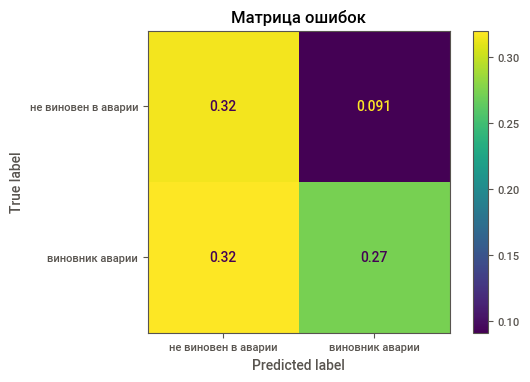

In [140]:
# Предсказание с использованием pipeline
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize='all')

# Отображение матрицы ошибок
cmd = ConfusionMatrixDisplay(cm, display_labels=['не виновен в аварии', 'виновник аварии'])
cmd.plot()
plt.title('Матрица ошибок')
plt.show()

- Истинно отрицательных ответов (не виновен в аварии) 0.32, истинно положительных ответов (виновен в аварии) TР = 0.27.
- Ложно положительных предсказаний меньше ложно отрицательных: 0.088 и 0.32, соответственно.

По результатам анализа, модель способна верно определить вину в аварии с вероятностью 0.27. Однако стоит отметить, что с вероятностью 0.32 действительно виновные лица могут остаться без уведомления от компании.

- Кривая ROC расположена выше кривой случайных ответов. Значение AUC = 0.64

Точность: 0.75
Полнота: 0.46


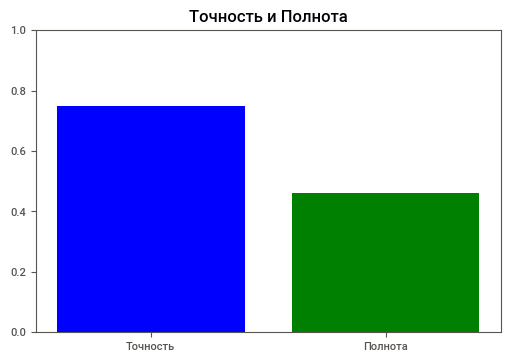

In [142]:
# Расчет точности и полноты
y_pred = pipeline.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Точность: {precision:.2f}")
print(f"Полнота: {recall:.2f}")

# Визуализация точности и полноты
plt.bar(['Точность', 'Полнота'], [precision, recall], color=['blue', 'green'])
plt.title('Точность и Полнота')
plt.ylim(0, 1)
plt.show()

Точность составляет 0.75, что означает, что когда модель предсказывает положительный класс, она правильно делает это примерно в 75% случаев. Полнота равна 0.45, что указывает на то, что модель успешно идентифицирует примерно 45% всех реальных положительных случаев в данных.

# Анализ важности факторов ДТП

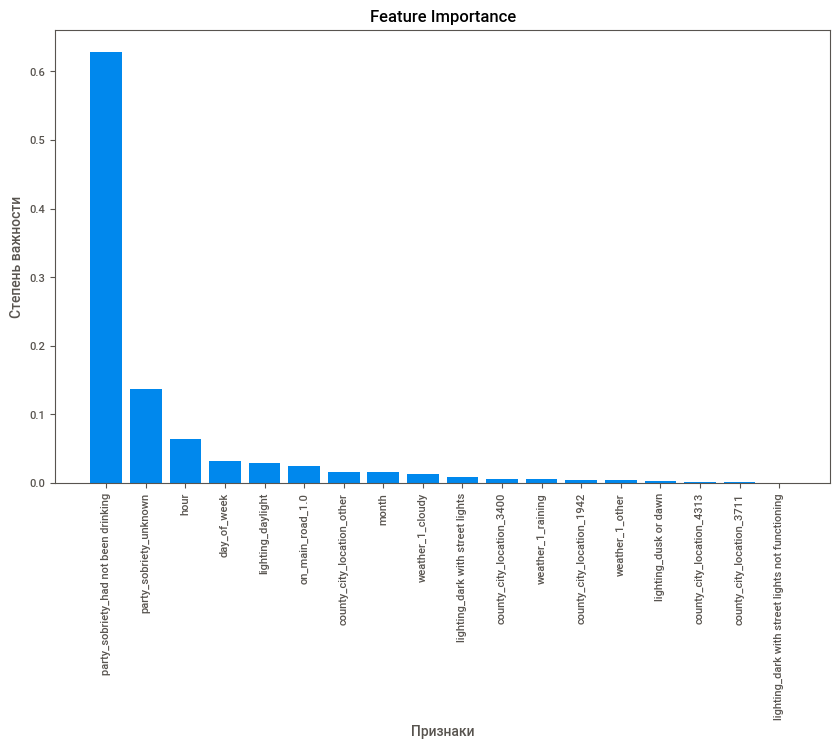

In [143]:
feature_names = []
feature_importances = pipeline.named_steps['randomforestclassifier'].feature_importances_

for transformer in column_transformer_forest.transformers_:
    transformer_name, transformer, columns = transformer
    if isinstance(transformer, OneHotEncoder):
        # OneHotEncoder
        for col, cats in zip(columns, transformer.categories_):
            feature_names.extend([f"{col}_{cat}" for cat in cats[1:]])
    else:
        # StandardScaler
        feature_names.extend(columns)

# Sorting feature importance
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.xlabel('Признаки')
plt.ylabel('Степень важности')
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.show()


Модель посчитала важными такие признаки как:
- трезвость водителя
- время суток поездки
- освещение
- день недели
- проходит ли поездка по главной дороге

In [144]:
# для обеспечения сбалансированности данных и корректного анализа,
# я оставлю равное количество обоих значений признака 'at_fault'.

df = data.copy()

# удаляю лишние строки со значением 1
rows_to_drop = df[df['at_fault'] == 1].sample(n=9533, random_state=1).index
df = df.drop(rows_to_drop)

print(df['at_fault'].value_counts())

0    20894
1    20894
Name: at_fault, dtype: int64


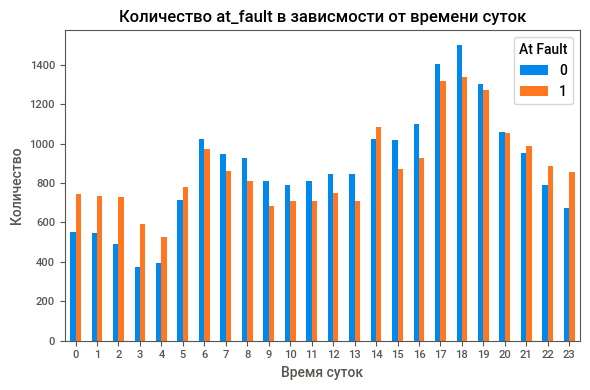

In [145]:
grouped = df.groupby(['hour', 'at_fault']).size().unstack(fill_value=0)

# Строим столбчатую диаграмму
grouped.plot(kind='bar', stacked=False)
plt.title('Количество at_fault в зависмости от времени суток')
plt.xlabel('Время суток')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(title='At Fault')
plt.tight_layout()

# Показываем график
plt.show()

Так как была проанализировано ранее зависимость целевым признаком и уровнем трезвости водителя (самым важным признаком модели), - был проведен анализ следующего по значимости признака - это время суток.

Судя по графику, с 22 часов до 5 утра вероятность стать виновником аварии увеличивается. Кроме того, есть небольшой пик вероятности в 14 и 20 часов.

Разработка надежной системы оценки рисков при предоставлении автомобиля водителю - сложная задача. Наличие используемых признаков недостаточно, хотя, безусловно, такие данные как проверка трезвости водителя, а также анализ времени суток является важными составляющими модели. Для проверки трезвости водителя можно использовать электронный алкотестер. При безконтактной аренде автомобилей алкотестеры могут быть установлены в машинах с возможностью автоматической отправки результатов в базу данных компании, чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место. В случае обнаружения алкоголя у водителя ему сообщается об отказе в предоставлении автомобиля.

Я считаю, что также крайне важно дополнить количество признаков для анализа модели: состояние автомобиля до выдачи ее клиенту; учитывать историю участия в авариях данного клиента, особенно если он ранее уже пользовался услугами этой каршеринговой компании. Кроме того, следует детально анализировать предполагаемые маршруты поездок, включая изучение статистики дорожных происшествий на различных участках и в разное время, что также влияет на оценку рисков.

# Отчет по проекту

**При создание модели были проведены следущие шаги:**

**1. Первичное исследование исходных таблиц:**
- Проверка соответствия количества таблиц и их названий
- Проверка набора данных в таблицах
- Проверка общего ключа
**2. Статистический анализ факторов ДТП.** 
Проанализировано:

**2.1. Время:**
- Большинство аварий происходит в первой половине года, с января по май (9.2-9.9%), с пиком в марте и наименьшим количеством в феврале. Во второй половине года, с июня по декабрь, доля аварий составляет 7.4-8%, с наименьшим числом случаев в июне, июле и ноябре (по 7.4%).
- Чаще всего происходят аварии по субботам - в 16.3% случаев, в понедельник вероятность наиболее низкая - 12.1%
- Чаще всего аварии происходят с 15 по 17 часов, что составляет 22.0% случаев, в то время как наименьшее количество аварий приходится на период с 0 до 6 утра - 13.7%.

**2.2. Серьезность повреждений:**
- Большинство аварий, а именно 90.5%, происходят на сухих дорогах, в то время как 9.0% случаев приходится на влажные дороги, 0.5% - на заснеженные и 0.1% - на грязные. Это объясняется тем, что в хорошую погоду больше людей выезжает на дороги, в то время как в плохую погоду активность снижается.

**2.3. Причины ДТП:**
- В 45.1% случаев, когда происходят аварии с участием других автомобилей, виновным оказывается клиент. Если же причиной сталы дорожные знаки, отбойник или другие факторы, клиент чаще всего остается невиновным, за исключением случаев, связанных со строениями, где вероятность вины клиента немного выше.

- Почти в половине случаев (53.9%) неизвестно состояние участника аварии. В случаях, когда состояние участника не установлено, вероятность его вины составляет 42.3%. Также видно, что наличие алкоголя в организме значительно увеличивает вероятность стать виновником аварии.

**2.4. Влияние характеристик автомобиля:**
- Хотя седаны и купе чаще участвуют в авариях из-за их распространенности на дорогах, вероятность попадания в аварию зависит от типа кузова автомобиля: минивены имеют немного более высокий процент аварийности, чем купе, в то время как седаны и хэтчбеки демонстрируют более низкие показатели вероятности попадания в аварию.

- Наблюдается небольшое различие в вероятности попадания в аварию в зависимости от типа коробки передач: автомобили с механической коробкой передач имеют чуть большую вероятность оказаться в аварии, чем те, у которых установлена автоматическая коробка передач.

- Нет явной корреляции между возрастом автомобиля и вероятностью его участия в авариях.

**2.5. Факторы аварии:**
- 95.3% аварий произошли из-за нарушения правил дорожного движения.
- В Лос-Анджелесе происходит наибольшее количество аварий, однако вероятность стать виновником аварии там составляет 43.99%, что ниже, чем в Ориндже и Сан-Диего.
- Аварии чаще всего случаются на шоссе (81.5%), реже на рампе (13.4%) и на перекрестке (5.2%). Вероятность стать виновником аварии на рампе немного выше, чем на других типах дорог.
- Самые распространенные виды дорожных происшествий включают столкновение сзади, боковой удар и боковое столкновение, где вероятность оказаться виновником составляет менее 50%.
- Случаи аварий, связанных с опрокидыванием машины и ударом объекта, имеют высокий процент виновности водителей.

**3. Создание модели для оценки водительского риска:**

**3.1. Подготовка набора данных.**

**3.2. Предобработка и анализ отобранных данных:**
**Проанализировано:**
- В основном данные об авариях за первую половину года.
- Распределение аварий по дням недели и часам соответствует распределению из первичной таблицы.
- Признак at_fault распределен сбалансированно: распределение 1 и 0 составляет 51% и 49% соответственно.
- Изначально отобранные признаки party_drug_physical и road_condition_1 удалены. Первый — из-за большого количества пропусков в данных, второй — из-за того, что 97% данных относятся к одной категории, что делает признак неинформативным.
- В темное время суток шанс стать виновником аварии выше.
- Вероятность стать виновником аварии на второстепенной дороге выше.
- Когда состояние участника неизвестно или он точно пьян, вероятность его вины в аварии возрастает.
- Когда погода не ясная, вероятность быть виновником аварии чуть выше.

**Обработка данных:**
- В столбце lighting объединены категории 'dark with no street lights' и 'dark with street lights not functioning', так как с точки зрения водителя, категории объясняют одну и ту же ситуацию.
- В столбце county_city_location я оставила первые пять значений, а остальные объединила в other.
- Из численного признака distance я создала булев признак, обозначив присутствие на главной дороге как True.
- Значения "impairment unknown" и "not applicable" объединены в категорию 'unknown'. Также объединены значения "had been drinking, under influence", "had been drinking, impairment unknown", "had been drinking, not under influence" под общим термином "had been drinking".
- В столбце weather1 категории fog, snowing, wind объединены с other.
- Проведена проверка на наличие дубликатов.
- Пропуски заполнены медианными значениями.

**3.4. Подготовка обучающей и тестовой выборки**

**3.5. Поиск лучшей модели: обучение и анализ**

Созданы три модели: RandomForestClassifier, CatBoostClassifier и LGBMClassifier. Каждая с перебором гиперпараметров.

Расчет моделей происходит как с применением SMOTETomek, так и с балансировкой классов с помощью гиперпараметров. 

В качестве метрики применяется average_precision.

**Лучашя модель RandomForestClassifier с применением SMOTETomek, с параметрами:**
- n_estimators = 150
- max_depth = 6,
- min_samples_split = 2

**3.6. Проверка лучшей модели**

- Истинно отрицательных ответов (не виновен в аварии) 0.32, истинно положительных ответов (виновен в аварии) TР = 0.27.
- Ложно положительных предсказаний меньше ложно отрицательных: 0.088 и 0.32, соответственно.

По результатам анализа, модель способна верно определить вину в аварии с вероятностью 0.27. Однако стоит отметить, что с вероятностью 0.32 действительно виновные лица могут остаться без уведомления от компании.

- Кривая ROC:
- Кривая ROC расположена выше кривой случайных ответов. Значение AUC = 0.64.

- Точность и полнота:
Точность составляет 0.75, что означает, что когда модель предсказывает положительный класс, она правильно делает это примерно в 75% случаев. Полнота равна 0.45, что указывает на то, что модель успешно идентифицирует примерно 45% всех реальных положительных случаев в данных.
  
**3.7.Анализ важностей факторов ДТП**

Модель посчитала важными такие признаки как:
- трезвость водителя
- время суток поездки
- освещение
- день недели
- проходит ли поездка по главной дороге

Так как была проанализировано ранее зависимость целевым признаком и уровнем трезвости водителя (самым важным признаком модели), - был проведен анализ следующего по значимости признака - это время суток.

Судя по графику, с 22 часов до 5 утра вероятность стать виновником аварии увеличивается. Кроме того, есть небольшой пик вероятности в 14 и 20 часов.

Разработка надежной системы оценки рисков при предоставлении автомобиля водителю - сложная задача. Наличие используемых признаков недостаточно, хотя, безусловно, такие данные как проверка трезвости водителя, а также анализ времени суток является важными составляющими модели. Для проверки трезвости водителя можно использовать электронный алкотестер. При безконтактной аренде автомобилей алкотестеры могут быть установлены в машинах с возможностью автоматической отправки результатов в базу данных компании, чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место. В случае обнаружения алкоголя у водителя ему сообщается об отказе в предоставлении автомобиля.

Создание адекватной системы оценки риска при выдаче автомобилей в коршеринговой компании вполне возможно и даже необходимо для минимизации потенциальных финансовых потерь и снижения риска дорожнотраснспортных происшествий, способных нанести ущерб здоровью всех участников ДТП, привести к гибели людей. 

Я считаю, что также крайне важно дополнить количество признаков для анализа модели: 
- состояние автомобиля до выдачи ее клиенту; 
- учитывать стаж вождения, историю участия в авариях данного клиента, особенно если он ранее уже пользовался услугами этой каршеринговой компании.
- следует детально анализировать предполагаемые маршруты поездок, включая изучение статистики дорожных происшествий на различных участках и в разное время, что также влияет на оценку рисков. 